# Data Preparation

## Load data from sqlite3 in json

In [1]:
import colorcet as cc
from utils.db.get_data_db import get_data_json
## accuracy
from utils.information_retrieval import get_times_per_tt, get_confidence_per_tt, get_answers_scores_MCO, get_answers_scores_SCO, add_to_data_T1, add_to_data_T2_model

from adjustText import adjust_text
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

db_file_path = 'data/study_02.db'
data = get_data_json(db_file_path)

from matplotlib import pyplot as plt
# from matplotlib.text import Annotation
from matplotlib.gridspec import GridSpec
import seaborn as sns
p_all = {'AG':'blue','IG':'magenta','SG':'#32CD32','all':'#FFC831'}
p_plain = {'AG':'blue','IG':'magenta','SG':'#32CD32'}
hue_order = ['all','AG','IG','SG']
hue_order_plain = ['AG','IG','SG']

## Data cleaning

Remove any incomplete registration created when participants by mistake clicked multiple times the "Registration" button.

In [2]:
data_processed = {}
for p in data:
    if data[p]['status'] == "end" or data[p]['status'] == "end_thanks":
        data_processed[p] = data[p]

## Get observed Response Times, Accuracy, and Confidence per Task Type (TT) and group (IG, SG, AG)

<!-- There are 3 research questions in the study. -->

TT1: Given an intervention, which is the correct causal model?

TT2: Given a set of causal models and intervention, which interventions are sufficient to identify the causal model? Which is the correct causal model? 

----------------------

IG: Interaction Group

SG: Static Group

AG: Animation Group

<!-- The study consisted of 3 problems. Each problem was modelled by a different probabilistic model. There were 3 sets of questions in each problem with every set corresponding to one of the research questions. -->

<!-- The task ids per problem and RQ are following:

**Problem 1: Temperature in Scotland**

RQ1: t1

RQ2: t2, t3, t4

RQ3: t5

**Problem 2: Random real-number generator**

RQ1: t6

RQ2: t7, t8, t9

RQ3: t10, t11

**Problem 3: Lorry drivers reaction times**

RQ1: t12, t13

RQ2: t14, t15, t16, t17

RQ3: t18, t19 -->

In [3]:
# task ids per TT
t_ids = {}
t_ids['T1'] = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
t_ids['T2'] = ['t11','t12','t13','t14','t15','t16']

## times
times_i, times_s, times_a = get_times_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>
## confidence
conf_i, conf_s, conf_a = get_confidence_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>

## TT1
## corr answ taken responses as multiple choice selections
answ_sc_i_multi, answ_sc_s_multi, answ_sc_a_multi = get_answers_scores_MCO(data_processed, 
                                                                                                 t_ids['T1'], 
                                                                                                 db_file_path, 'T1') # returns Dict<t_id:List>
## corr answ taken responses as single selection
answ_sc_i_singl, answ_sc_s_singl, answ_sc_a_singl = get_answers_scores_SCO(data_processed, 
                                                                                               t_ids['T1'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
## TT2
answ_sc_i_model_T2, answ_sc_s_model_T2, answ_sc_a_model_T2 = get_answers_scores_SCO(data_processed, 
                                                                                               t_ids['T2'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
answ_sc_i_interv_T2, answ_sc_s_interv_T2, answ_sc_a_interv_T2 = get_answers_scores_MCO(data_processed, 
                                                                                                 t_ids['T2'], 
                                                                                                 db_file_path, 'T2') # returns Dict<t_id:List>
## demographic questions answers
d_ids = ['d1','d2','d3','d4','d5']
answ_demo_i = {}
answ_demo_s = {}
answ_demo_a = {}
for d in d_ids:
    answ_demo_i[d] = [p_details['d_answers'][d]['option'] 
            for p,p_details in data_processed.items() 
            if p_details['mode'] == 'i' ]
    answ_demo_s[d] = [p_details['d_answers'][d]['option'] 
            for p,p_details in data_processed.items() 
            if p_details['mode'] == 's' ]
    answ_demo_a[d] = [p_details['d_answers'][d]['option'] 
            for p,p_details in data_processed.items() 
            if p_details['mode'] == 'a' ]
    
## user exp questions answers
ue_ids = ['ue1','ue2','ue3']
answ_ue_i = {}
answ_ue_s = {}
answ_ue_a = {}
for d in ue_ids:
    answ_ue_i[d] = [p_details['ue_answers'][d]['slider_value'] 
            for p,p_details in data_processed.items() 
            if p_details['mode'] == 'i' ]
    answ_ue_s[d] = [p_details['ue_answers'][d]['slider_value'] 
            for p,p_details in data_processed.items() 
            if p_details['mode'] == 's' ]
    answ_ue_a[d] = [p_details['ue_answers'][d]['slider_value'] 
            for p,p_details in data_processed.items() 
            if p_details['mode'] == 'a' ]

### Test Data Retrieval

In [4]:
from collections import Counter
times = {}
for p in data_processed:
    if data_processed[p]['mode'] == 'i':
        for t in data_processed[p]['t_answers']:
            if t not in times:
                times[t] = []
            times[t].append(data_processed[p]['t_answers'][t]['options'])
            # if len(data_processed[p]['t_answers'][t]['options'])>1 and t in t_ids['T2']:                
                # print([(t,p,k) for (k,v) in Counter(data_processed[p]['t_answers'][t]['options']).items() if v > 1])
                # print(t,p,data_processed[p]['t_answers'][t]['options'])
            times[t].append(data_processed[p]['t_answers'][t]['model_opt'])
            #print(t,data_processed[p]['t_answers'][t]['response_time'])
## times['t10'] vs answ_sc_i_multi['t10']
times['t11']

[['Atomic intervention on tiredness'],
 'Causal Model 3',
 ['Atomic intervention on insomnia',
  'Atomic intervention on anxiety',
  'Atomic intervention on tiredness'],
 'Causal Model 2',
 ['Atomic intervention on insomnia'],
 'Causal Model 2',
 ['Atomic intervention on anxiety'],
 'Causal Model 2',
 ['Atomic intervention on tiredness'],
 'Causal Model 2',
 ['Atomic intervention on tiredness'],
 'Causal Model 3',
 ['Atomic intervention on insomnia'],
 'Causal Model 1',
 ['Atomic intervention on tiredness'],
 'Causal Model 3',
 ['Atomic intervention on tiredness'],
 'Causal Model 2',
 ['Atomic intervention on insomnia'],
 'Causal Model 2',
 ['Atomic intervention on insomnia', 'Atomic intervention on anxiety'],
 'Causal Model 2']

In [13]:
answ_sc_i_interv_T2

{'t11': [1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 2],
 't12': [1, 1, 2, 2, 2, 3, 2, 2, 0, 2, 1],
 't13': [2, 1, 1, 2, 3, 1, 2, 1, 1, 2, 2],
 't14': [0, 3, 1, 1, 2, 2, 0, 2, 0, 1, 1],
 't15': [1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1],
 't16': [3, 2, 1, 3, 2, 2, 2, 1, 1, 2, 2]}

### Data Preparation for Plotting

In [5]:
task_types = {'t1':'atomic',
              't2':'atomic',
              't3':'atomic',
              't4':'atomic',
              't5':'atomic',
              't6':'shift',
              't7':'shift',
              't8':'variance',
              't9':'variance',
              't10':'variance',
              't11':'atomic','t12':'atomic','t13':'shift','t14':'shift','t15':'variance','t16':'variance'}

participants_i = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 'i' ]
participants_s = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 's']
participants_a = [p for p,p_details in data_processed.items() 
                      if p_details['mode'] == 'a']

#### T1

In [6]:
## T1
data = {'accuracy': [], 'accuracy_ham':[],'time': [], 'conf': [], 'condition': [], 'task':[], 'participant':[], 'intervention':[], 'd1':[],'d2':[],'d3':[],'d4':[],'d5':[]}

## INTERACTION
answers = answ_sc_i_singl
answers_multi = answ_sc_i_multi
answ_demo = answ_demo_i
times = times_i['T1']
confidence = conf_i['T1']
mode = 'IG'
participants = participants_i
add_to_data_T1(data, task_types, answers,answers_multi,answ_demo, times,confidence,mode,participants)

## ANIMATION
answers = answ_sc_a_singl
answers_multi = answ_sc_a_multi
answ_demo = answ_demo_a
times = times_a['T1']
confidence = conf_a['T1']
mode = 'AG'
participants = participants_a
add_to_data_T1(data, task_types, answers,answers_multi,answ_demo,times,confidence,mode,participants)

## STATIC
answers = answ_sc_s_singl
answers_multi = answ_sc_s_multi
answ_demo = answ_demo_s
times = times_s['T1']
confidence = conf_s['T1']
mode = 'SG'
participants = participants_s
add_to_data_T1(data, task_types, answers,answers_multi,answ_demo,times,confidence,mode,participants)

df = pd.DataFrame.from_dict(data)

In [7]:
data_perf_per_part = {'participant_id':[], 'num_tasks_correct':[], 'condition':[], 'mean_conf':[],'mean_time':[], 'd1':[],'d2':[],'d3':[],'d4':[],'d5':[],'ue1':[],'ue2':[],'ue3':[]}
df_tmp = df[df['condition']!='all']
for p in df['participant'].unique():
    ## per condition
    data_perf_per_part['num_tasks_correct'].append(df_tmp[df_tmp['participant'] == p]['accuracy'].sum())
    data_perf_per_part['mean_conf'].append(df_tmp[df_tmp['participant'] == p]['conf'].mean())
    data_perf_per_part['mean_time'].append(df_tmp[df_tmp['participant'] == p]['time'].mean())
    data_perf_per_part['participant_id'].append(str(p))
    data_perf_per_part['d1'].append(data_processed[p]['d_answers']['d1']['option']) 
    data_perf_per_part['d2'].append(data_processed[p]['d_answers']['d2']['option']) 
    data_perf_per_part['d3'].append(data_processed[p]['d_answers']['d3']['option']) 
    data_perf_per_part['d4'].append(data_processed[p]['d_answers']['d4']['option']) 
    data_perf_per_part['d5'].append(data_processed[p]['d_answers']['d5']['option']) 
    data_perf_per_part['ue1'].append(data_processed[p]['ue_answers']['ue1']['slider_value']) 
    data_perf_per_part['ue2'].append(data_processed[p]['ue_answers']['ue2']['slider_value']) 
    data_perf_per_part['ue3'].append(data_processed[p]['ue_answers']['ue3']['slider_value']) 
    if p in participants_i:
        data_perf_per_part['condition'].append('IG')
    elif p in participants_a:
        data_perf_per_part['condition'].append('AG')
    elif p in participants_s:
        data_perf_per_part['condition'].append('SG')
    ## all
    data_perf_per_part['num_tasks_correct'].append(df_tmp[df_tmp['participant'] == p]['accuracy'].sum())
    data_perf_per_part['mean_conf'].append(df_tmp[df_tmp['participant'] == p]['conf'].mean())
    data_perf_per_part['mean_time'].append(df_tmp[df_tmp['participant'] == p]['time'].mean())
    data_perf_per_part['participant_id'].append(str(p))
    data_perf_per_part['condition'].append('all')
    data_perf_per_part['d1'].append(data_processed[p]['d_answers']['d1']['option']) 
    data_perf_per_part['d2'].append(data_processed[p]['d_answers']['d2']['option']) 
    data_perf_per_part['d3'].append(data_processed[p]['d_answers']['d3']['option']) 
    data_perf_per_part['d4'].append(data_processed[p]['d_answers']['d4']['option']) 
    data_perf_per_part['d5'].append(data_processed[p]['d_answers']['d5']['option']) 
    data_perf_per_part['ue1'].append(data_processed[p]['ue_answers']['ue1']['slider_value']) 
    data_perf_per_part['ue2'].append(data_processed[p]['ue_answers']['ue2']['slider_value']) 
    data_perf_per_part['ue3'].append(data_processed[p]['ue_answers']['ue3']['slider_value']) 

df_perf_part = pd.DataFrame.from_dict(data_perf_per_part)
df_perf_part['ue3-ue2'] = df_perf_part['ue3'] - df_perf_part['ue2']

#### T2

In [8]:
## T2 - MODELs
data = {'accuracy': [],"accuracy_intervention":[], 'time': [], 'conf': [], 'condition': [], 'task':[], 'participant':[], 'intervention':[], 'd1':[],'d2':[],'d3':[],'d4':[],'d5':[]}

## INTERACTION
answers = answ_sc_i_model_T2
answer_interv = answ_sc_i_interv_T2
answ_demo = answ_demo_i
times = times_i['T2']
confidence = conf_i['T2']
mode = 'IG'
participants = participants_i
add_to_data_T2_model(data, task_types, answers, answer_interv, answ_demo,times,confidence,mode,participants)

## ANIMATION
answers = answ_sc_a_model_T2
answer_interv = answ_sc_a_interv_T2
answ_demo = answ_demo_a
times = times_a['T2']
confidence = conf_a['T2']
mode = 'AG'
participants = participants_a
add_to_data_T2_model(data, task_types, answers, answer_interv, answ_demo,times,confidence,mode,participants)

## STATIC
answers = answ_sc_s_model_T2
answer_interv = answ_sc_s_interv_T2
answ_demo = answ_demo_s
times = times_s['T2']
confidence = conf_s['T2']
mode = 'SG'
participants = participants_s
add_to_data_T2_model(data, task_types, answers, answer_interv, answ_demo,times,confidence,mode,participants)

df_T2_model = pd.DataFrame.from_dict(data)

### Performance

<AxesSubplot: xlabel='participant_id', ylabel='num_tasks_correct'>

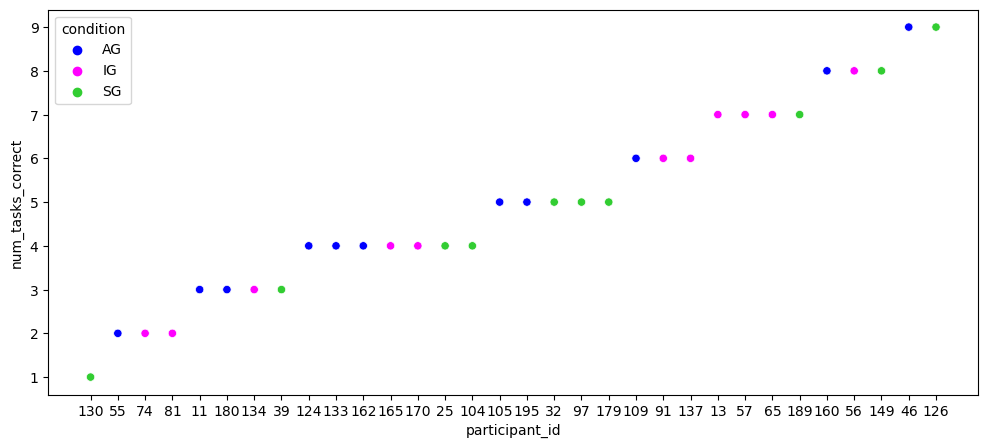

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.scatterplot(df_perf_part[df_perf_part['condition']!='all'].sort_values(['num_tasks_correct','condition']), x='participant_id', y='num_tasks_correct', hue = 'condition', ax = ax, palette = p_plain, hue_order = hue_order_plain)

[Text(0.5, 0, "Participants' Response Time")]

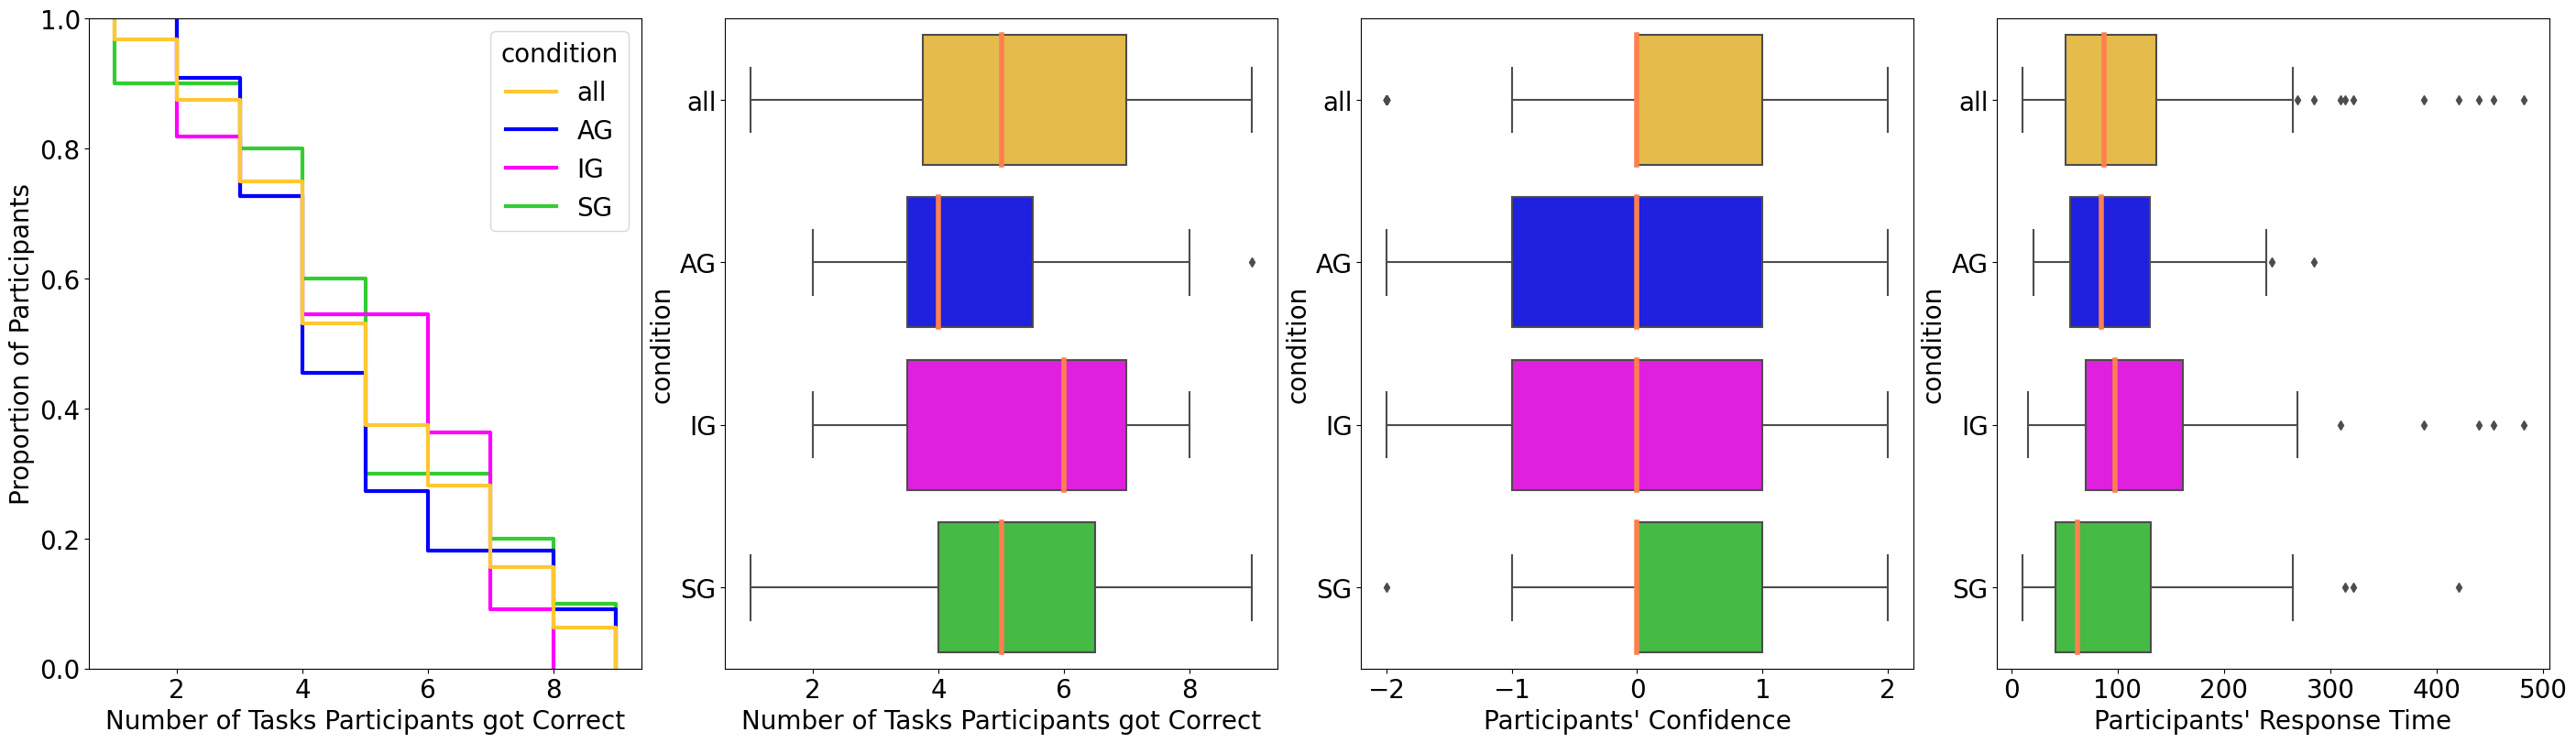

In [9]:
fig = plt.figure(constrained_layout=True,figsize=(28, 8))
font_size = 20
plt.rcParams.update({'font.size': font_size})
gs = GridSpec(1, 8, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[0, 2:4])
ax2 = fig.add_subplot(gs[0, 4:6])
ax3 = fig.add_subplot(gs[0, 6:8])

g0 = sns.ecdfplot(df_perf_part.sort_values(['num_tasks_correct','condition']), x='num_tasks_correct',  hue = 'condition', complementary=True, palette = p_all, hue_order=hue_order, ax = ax0,linewidth=3)
ax0.tick_params(axis='both')

g1 = sns.boxplot(data=df_perf_part, x="num_tasks_correct", y="condition", palette = p_all, hue_order=hue_order, order = hue_order, ax=ax1,medianprops={"color": "coral",'linewidth':4})
ax1.tick_params(axis='both')

g2 = sns.boxplot(data=df, x="conf", y="condition", palette = p_all, hue_order=hue_order, order = hue_order, ax=ax2,medianprops={"color": "coral",'linewidth':4})
ax2.tick_params(axis='both')

g3 = sns.boxplot(data=df, x="time", y="condition", palette = p_all, hue_order=hue_order, order = hue_order, ax=ax3,medianprops={"color": "coral",'linewidth':4})
ax3.tick_params(axis='both')

g_axes = [ax0,ax1,ax2,ax3]
for i,ax in enumerate(g_axes):
    ax.tick_params(axis='both', labelsize=font_size)
    ax.yaxis.label.set_size(font_size)
    ax.title.set_size(font_size)

ax0.set(ylabel="Proportion of Participants")
ax0.set(xlabel="Number of Tasks Participants got Correct")
ax1.set(xlabel="Number of Tasks Participants got Correct")
ax2.set(xlabel="Participants' Confidence")
ax3.set(xlabel="Participants' Response Time")

# plt.savefig('ch6_Fig8.pdf',dpi=300)

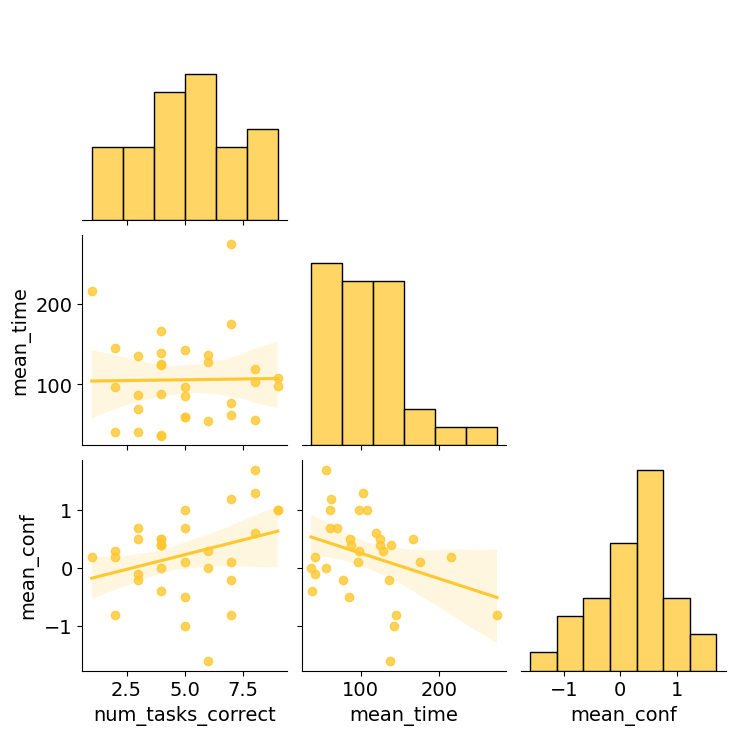

In [11]:
font_size = 14
plt.rcParams.update({'font.size': font_size})
g=sns.pairplot(df_perf_part[df_perf_part['condition']=='all'], vars=['num_tasks_correct','mean_time','mean_conf'],corner=True, diag_kind='hist',kind = 'reg',plot_kws={'color':'#FFC831'},diag_kws={'color':'#FFC831'})
# g.get_figure().savefig('fig1.pdf',dpi=300)

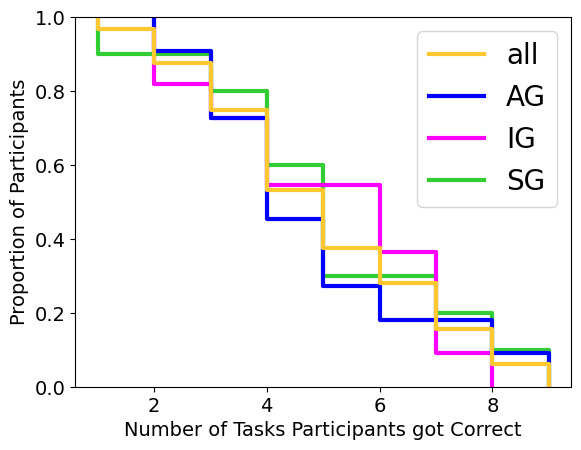

In [144]:
g = sns.ecdfplot(df_perf_part.sort_values(['num_tasks_correct','condition']), x='num_tasks_correct',  hue = 'condition', complementary=True, palette = p_all, hue_order=hue_order, linewidth=3)
g.legend_.set_title(None)
ax = g.get_figure().axes[0]
font_size = 14
ax.set(ylabel="Proportion of Participants")
ax.set(xlabel="Number of Tasks Participants got Correct")
ax.tick_params(axis='both', labelsize=font_size)
ax.yaxis.label.set_size(font_size)
ax.xaxis.label.set_size(font_size)
ax.title.set_size(font_size)
# g1.get_figure().savefig('fig1.pdf',dpi=300)

### Performance - Demographics

<AxesSubplot: xlabel='num_tasks_correct', ylabel='d3'>

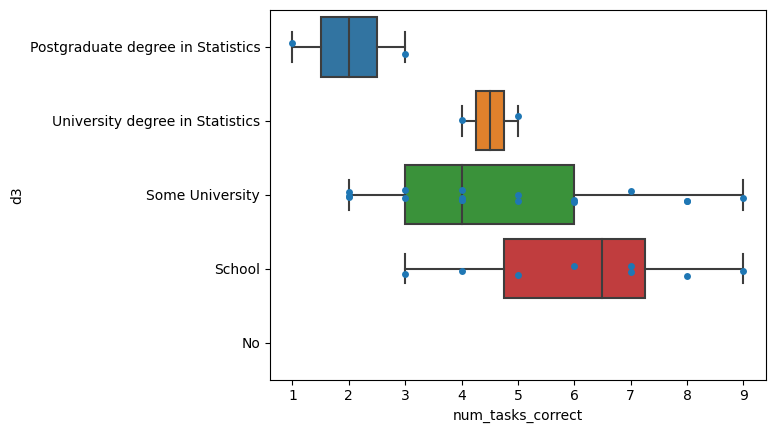

In [26]:
g = sns.boxplot(data=df_perf_part[df_perf_part['condition']=='all'], x="num_tasks_correct", y="d3", order = ['Postgraduate degree in Statistics', 'University degree in Statistics', 'Some University', 'School','No'])
sns.stripplot(data=df_perf_part[df_perf_part['condition']=='all'],ax =g.axes, x="num_tasks_correct", y="d3",order = ['Postgraduate degree in Statistics', 'University degree in Statistics', 'Some University', 'School','No'])

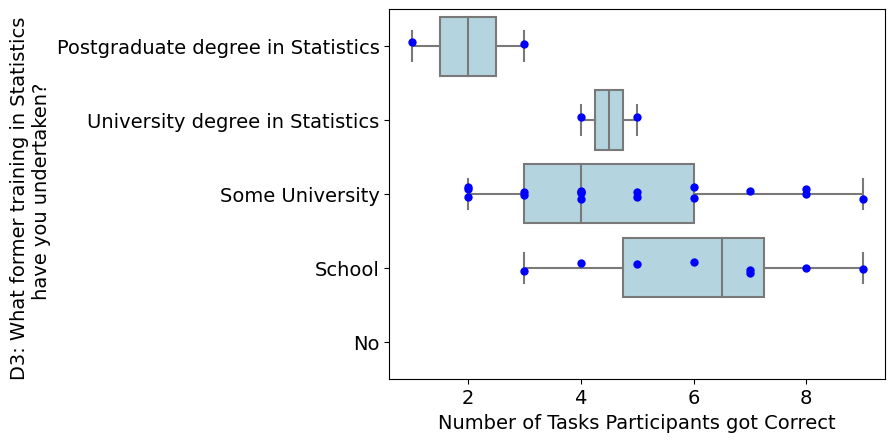

In [26]:
g=sns.stripplot(data=df_perf_part[df_perf_part['condition']=='all'], color='blue', size=6, x="num_tasks_correct", y="d3",order = ['Postgraduate degree in Statistics', 'University degree in Statistics', 'Some University', 'School','No'])

ax = g.get_figure().axes[0]
sns.boxplot(data=df_perf_part[df_perf_part['condition']=='all'], ax=ax, color='lightblue',x="num_tasks_correct", y="d3", order = ['Postgraduate degree in Statistics', 'University degree in Statistics', 'Some University', 'School','No'])
font_size = 14
ax.set(ylabel="D3: What former training in Statistics \n have you undertaken?")
ax.set(xlabel="Number of Tasks Participants got Correct")
ax.tick_params(axis='both', labelsize=font_size)
ax.yaxis.label.set_size(font_size)
ax.xaxis.label.set_size(font_size)
ax.title.set_size(font_size)
# g.get_figure().savefig('ch6_demo_perf_d3.svg',dpi=300)

<AxesSubplot: >

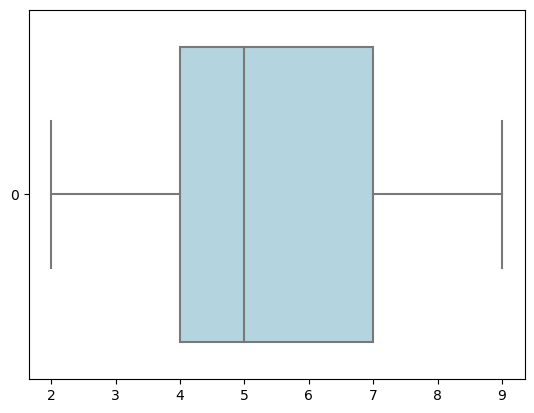

In [47]:
most= df_perf_part[df_perf_part['condition']=='all']
l1=list(most[most['d3'] == 'Some University']['num_tasks_correct'])
l2=list(most[most['d3'] == 'School']['num_tasks_correct'])

sns.boxplot(l1+l2, color='lightblue', orient='h')

<AxesSubplot: >

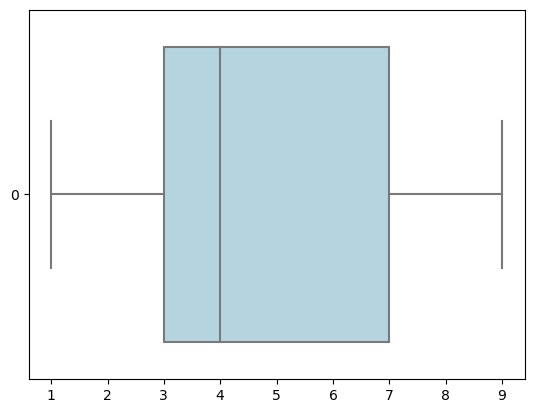

In [50]:
most= df_perf_part[df_perf_part['condition']=='all']
l1=list(most[most['d4'] == 'Definetely yes']['num_tasks_correct'])
l2=list(most[most['d4'] == 'Probably yes']['num_tasks_correct'])

sns.boxplot(l1+l2, color='lightblue', orient='h')

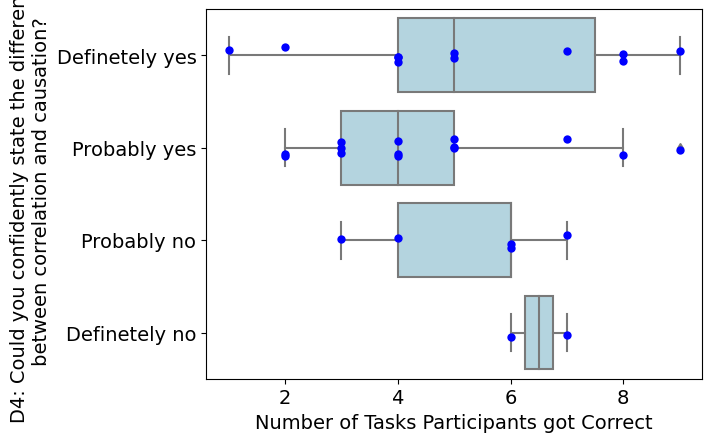

In [74]:
g=sns.stripplot(data=df_perf_part[df_perf_part['condition']=='all'], color='blue', size=6, x="num_tasks_correct", y="d4",order = ['Definetely yes', 'Probably yes', 'Probably no', 'Definetely no'])

ax = g.get_figure().axes[0]
sns.boxplot(data=df_perf_part[df_perf_part['condition']=='all'], ax=ax, color='lightblue',x="num_tasks_correct", y="d4", order = ['Definetely yes', 'Probably yes', 'Probably no', 'Definetely no'])

font_size = 14
ax.set(ylabel="D4: Could you confidently state the difference \n between correlation and causation?")
ax.set(xlabel="Number of Tasks Participants got Correct")
ax.tick_params(axis='both', labelsize=font_size)
ax.yaxis.label.set_size(font_size)
ax.xaxis.label.set_size(font_size)
ax.title.set_size(font_size)
# g.get_figure().savefig('ch6_demo_perf_d4.svg',dpi=300)

### Performance - User Experience

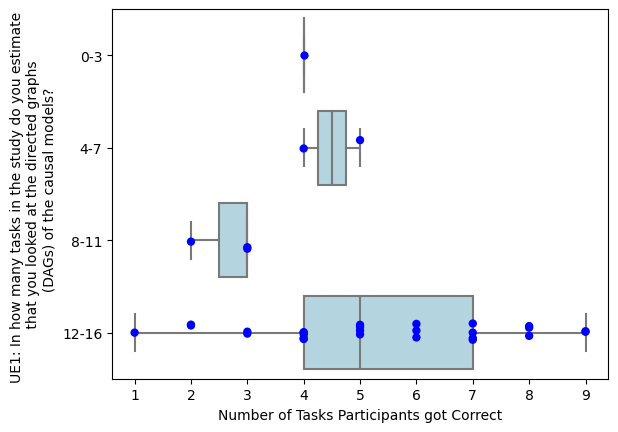

In [77]:
most= df_perf_part[df_perf_part['condition']=='all']
l0=list(most[most['ue1'] == 0]['num_tasks_correct'])
l1=list(most[most['ue1'] == 1]['num_tasks_correct'])
l2=list(most[most['ue1'] == 2]['num_tasks_correct'])
l3=list(most[most['ue1'] == 3]['num_tasks_correct'])
l4=list(most[most['ue1'] == 4]['num_tasks_correct'])
l5=list(most[most['ue1'] == 5]['num_tasks_correct'])
l6=list(most[most['ue1'] == 6]['num_tasks_correct'])
l7=list(most[most['ue1'] == 7]['num_tasks_correct'])
l8=list(most[most['ue1'] == 8]['num_tasks_correct'])
l9=list(most[most['ue1'] == 9]['num_tasks_correct'])
l10=list(most[most['ue1'] == 10]['num_tasks_correct'])
l11=list(most[most['ue1'] == 11]['num_tasks_correct'])
l12=list(most[most['ue1'] == 12]['num_tasks_correct'])
l13=list(most[most['ue1'] == 13]['num_tasks_correct'])
l14=list(most[most['ue1'] == 14]['num_tasks_correct'])
l15=list(most[most['ue1'] == 15]['num_tasks_correct'])
l16=list(most[most['ue1'] == 16]['num_tasks_correct'])
l0_4 = l0+l1+l2+l3
l4_8 = l4+l5+l6+l7
l8_12 = l8+l9+l10+l11
l12_16 = l12+l13+l14+l16

g = sns.boxplot([l0_4,l4_8,l8_12,l12_16], color='lightblue', orient='h')
ax = g.get_figure().axes[0]
sns.stripplot([l0_4,l4_8,l8_12,l12_16], color='blue', size=6, orient='h',palette=4*['blue'])
ax.set_yticklabels(['0-3','4-7','8-11','12-16'])
ax.set(ylabel="UE1: In how many tasks in the study do you estimate \n that you looked at the directed graphs \n  (DAGs) of the causal models?")
ax.set(xlabel="Number of Tasks Participants got Correct")
# g.get_figure().savefig('ch6_ue_perf_ue1.svg',dpi=300)

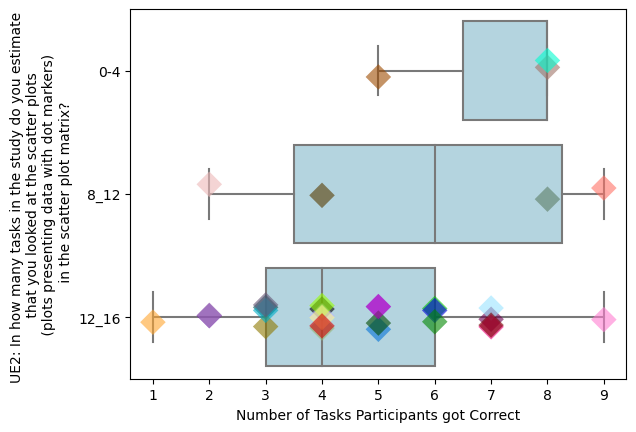

In [58]:
most= df_perf_part[df_perf_part['condition']=='all']
l0=most[most['ue2'] == 0][['num_tasks_correct','participant_id']]
l1=most[most['ue2'] == 1][['num_tasks_correct','participant_id']]
l2=most[most['ue2'] == 2][['num_tasks_correct','participant_id']]
l3=most[most['ue2'] == 3][['num_tasks_correct','participant_id']]
l4=most[most['ue2'] == 4][['num_tasks_correct','participant_id']]
l5=most[most['ue2'] == 5][['num_tasks_correct','participant_id']]
l6=most[most['ue2'] == 6][['num_tasks_correct','participant_id']]
l7=most[most['ue2'] == 7][['num_tasks_correct','participant_id']]
l8=most[most['ue2'] == 8][['num_tasks_correct','participant_id']]
l9=most[most['ue2'] == 9][['num_tasks_correct','participant_id']]
l10=most[most['ue2'] == 10][['num_tasks_correct','participant_id']]
l11=most[most['ue2'] == 11][['num_tasks_correct','participant_id']]
l12=most[most['ue2'] == 12][['num_tasks_correct','participant_id']]
l13=most[most['ue2'] == 13][['num_tasks_correct','participant_id']]
l14=most[most['ue2'] == 14][['num_tasks_correct','participant_id']]
l15=most[most['ue2'] == 15][['num_tasks_correct','participant_id']]
l16=most[most['ue2'] == 16][['num_tasks_correct','participant_id']]
l0_4 = pd.concat([l0,l1,l2,l3])
l0_4['cat'] = ['0-4']*len(l0_4)
l4_8 = pd.concat([l4,l5,l6,l7])
l4_8['cat'] = ['4_8']*len(l4_8)
l8_12 = pd.concat([l8,l9,l10,l11])
l8_12['cat'] = ['8_12']*len(l8_12)
l12_16 = pd.concat([l12,l13,l14,l16])
l12_16['cat'] = ['12_16']*len(l12_16)
l1all = pd.concat([l0_4,l4_8,l8_12,l12_16])
g = sns.boxplot(l1all, color='lightblue',x='num_tasks_correct',y='cat', orient='h')
ax = g.get_figure().axes[0]
p=sns.color_palette(cc.glasbey, n_colors=32)
sns.stripplot(l1all, x='num_tasks_correct', hue = 'participant_id',y='cat', size=13,marker='D',alpha=0.6, orient='h', palette=p,hue_order=list(np.sort((l['participant_id'].unique()))))
ax.set(ylabel="UE2: In how many tasks in the study do you estimate \n that you looked at the scatter plots \n (plots presenting data with dot markers) \n in the scatter plot matrix?")
ax.set(xlabel="Number of Tasks Participants got Correct")
g.legend_.remove()
g.get_figure().savefig('ch6_ue_perf_ue2.svg',dpi=300)

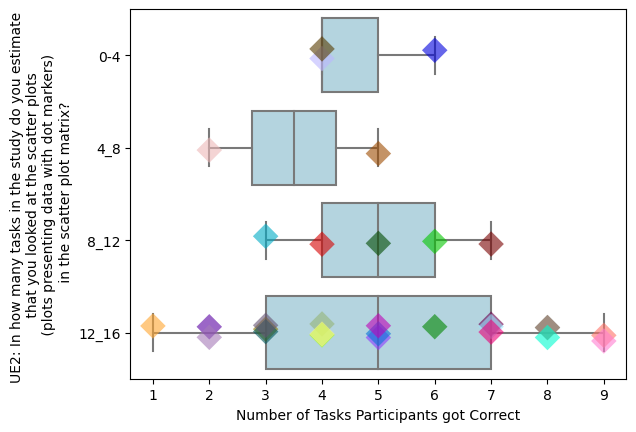

In [60]:
most= df_perf_part[df_perf_part['condition']=='all']
l0=most[most['ue3'] == 0][['num_tasks_correct','participant_id']]
l1=most[most['ue3'] == 1][['num_tasks_correct','participant_id']]
l2=most[most['ue3'] == 2][['num_tasks_correct','participant_id']]
l3=most[most['ue3'] == 3][['num_tasks_correct','participant_id']]
l4=most[most['ue3'] == 4][['num_tasks_correct','participant_id']]
l5=most[most['ue3'] == 5][['num_tasks_correct','participant_id']]
l6=most[most['ue3'] == 6][['num_tasks_correct','participant_id']]
l7=most[most['ue3'] == 7][['num_tasks_correct','participant_id']]
l8=most[most['ue3'] == 8][['num_tasks_correct','participant_id']]
l9=most[most['ue3'] == 9][['num_tasks_correct','participant_id']]
l10=most[most['ue3'] == 10][['num_tasks_correct','participant_id']]
l11=most[most['ue3'] == 11][['num_tasks_correct','participant_id']]
l12=most[most['ue3'] == 12][['num_tasks_correct','participant_id']]
l13=most[most['ue3'] == 13][['num_tasks_correct','participant_id']]
l14=most[most['ue3'] == 14][['num_tasks_correct','participant_id']]
l15=most[most['ue3'] == 15][['num_tasks_correct','participant_id']]
l16=most[most['ue3'] == 16][['num_tasks_correct','participant_id']]
l0_4 = pd.concat([l0,l1,l2,l3])
l0_4['cat'] = ['0-4']*len(l0_4)
l4_8 = pd.concat([l4,l5,l6,l7])
l4_8['cat'] = ['4_8']*len(l4_8)
l8_12 = pd.concat([l8,l9,l10,l11])
l8_12['cat'] = ['8_12']*len(l8_12)
l12_16 = pd.concat([l12,l13,l14,l16])
l12_16['cat'] = ['12_16']*len(l12_16)
l2all = pd.concat([l0_4,l4_8,l8_12,l12_16])
g = sns.boxplot(l2all, color='lightblue',x='num_tasks_correct',y='cat', orient='h')
ax = g.get_figure().axes[0]
sns.stripplot(l2all, x='num_tasks_correct', hue = 'participant_id',y='cat', size=13,marker='D',alpha=0.6, orient='h', palette=p,hue_order=list(np.sort((l['participant_id'].unique()))))
# ax.set_yticklabels(['0-3','4-7','8-11','12-16'])
ax.set(ylabel="UE2: In how many tasks in the study do you estimate \n that you looked at the scatter plots \n (plots presenting data with dot markers) \n in the scatter plot matrix?")
ax.set(xlabel="Number of Tasks Participants got Correct")
g.legend_.remove()
# g.get_figure().savefig('ch6_ue_perf_ue2.svg',dpi=300)

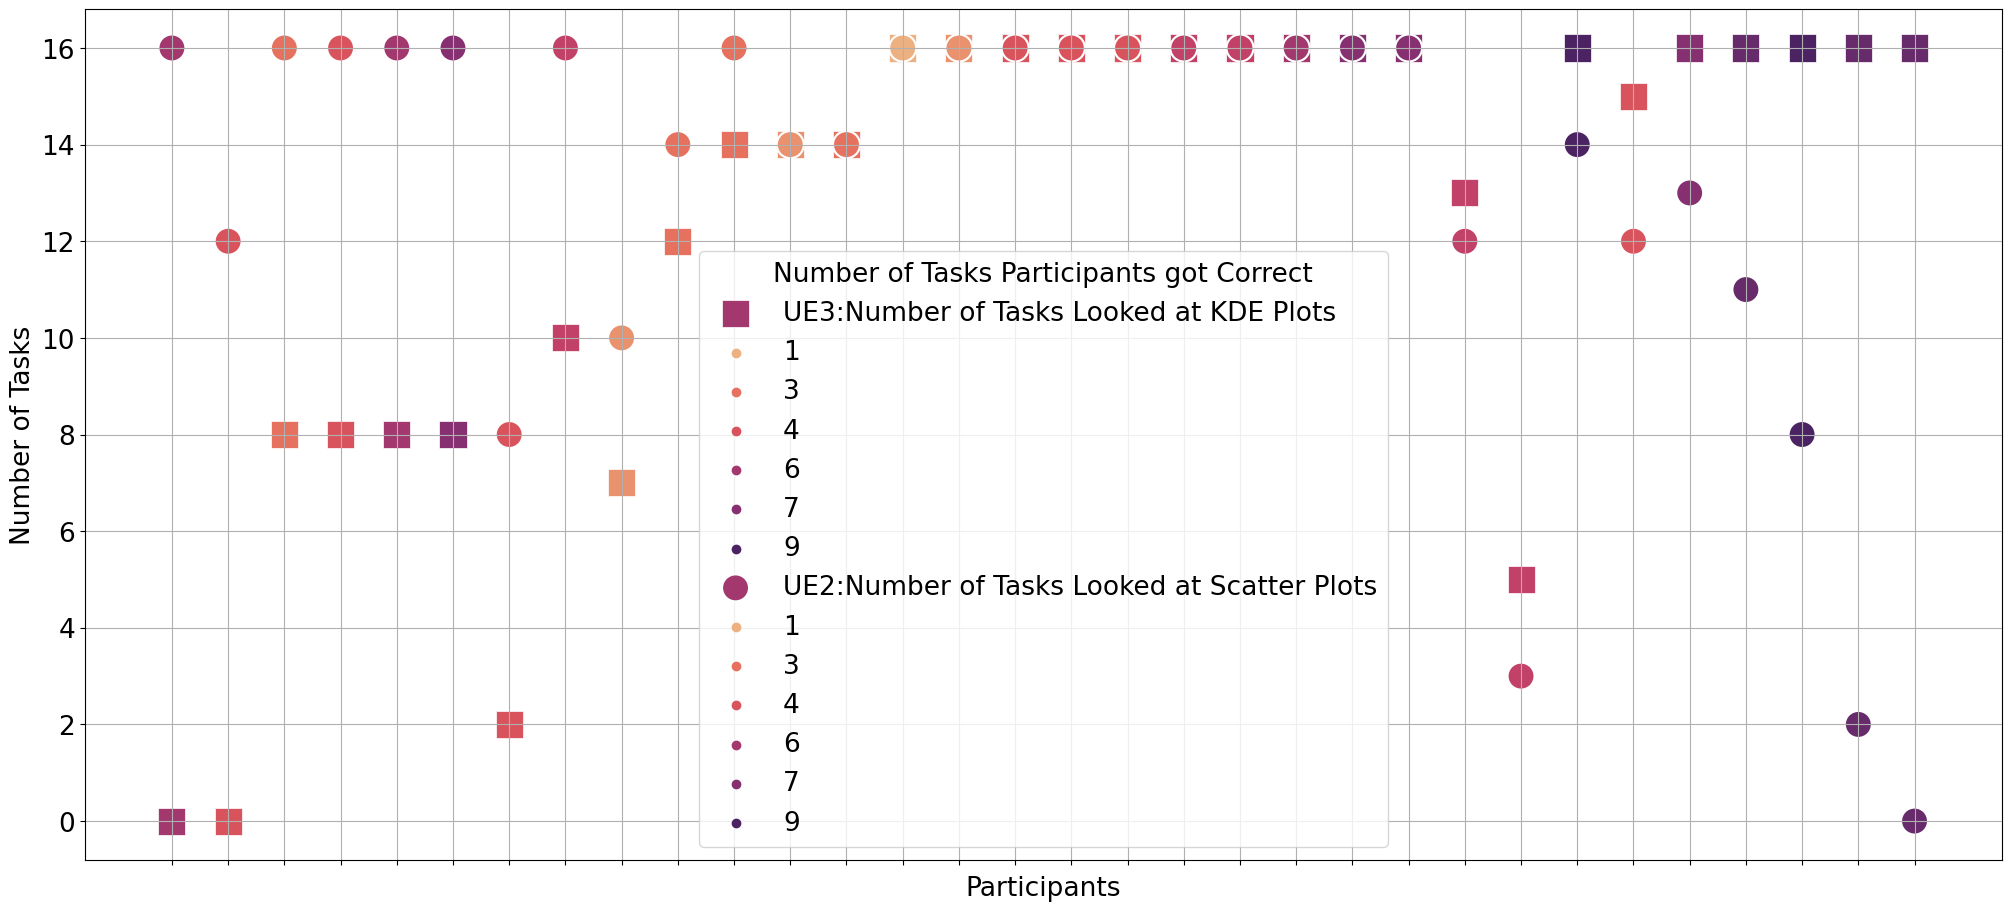

In [29]:
font_size = 19
plt.rcParams.update({'font.size': font_size})
fig = plt.figure(constrained_layout=True,figsize=(20, 9))
plt.grid()
# g = sns.scatterplot(df_perf_part.sort_values(['ue3','ue2','num_tasks_correct']), x="participant_id", y="ue2", color='blue',s =140,label='UE2:Number of Tasks Looked at Scatter Plots',hue='num_tasks_correct', palette='flare')
# sns.scatterplot(df_perf_part.sort_values(['ue3','ue2','num_tasks_correct']), x="participant_id", y="ue3",ax=g,marker='s',edgecolors='coral',linewidth=0.5,label='UE3:Number of Tasks Looked at KDE Plots',hue='num_tasks_correct', palette='flare')

g=sns.scatterplot(df_perf_part[df_perf_part['condition']=='all'].sort_values(['ue3-ue2','ue3','ue2','num_tasks_correct']), x="participant_id", y="ue3",marker='s',s =380,edgecolors='coral',linewidth=0.5,label='UE3:Number of Tasks Looked at KDE Plots',hue='num_tasks_correct', palette='flare')
sns.scatterplot(df_perf_part[df_perf_part['condition']=='all'].sort_values(['ue3-ue2','ue3','ue2','num_tasks_correct']), x="participant_id", y="ue2",ax=g, color='blue',s =380,label='UE2:Number of Tasks Looked at Scatter Plots',hue='num_tasks_correct', palette='flare')

g.legend_.set_title('Number of Tasks Participants got Correct')
p=[]
for i in range(32):
    # p.append("p"+str(i))
    p.append("")
g.set_xticklabels(p)
g.set(ylabel='Number of Tasks')
g.set(xlabel='Participants')
g.get_figure().savefig('ch6_ue_perf.svg',dpi=300)

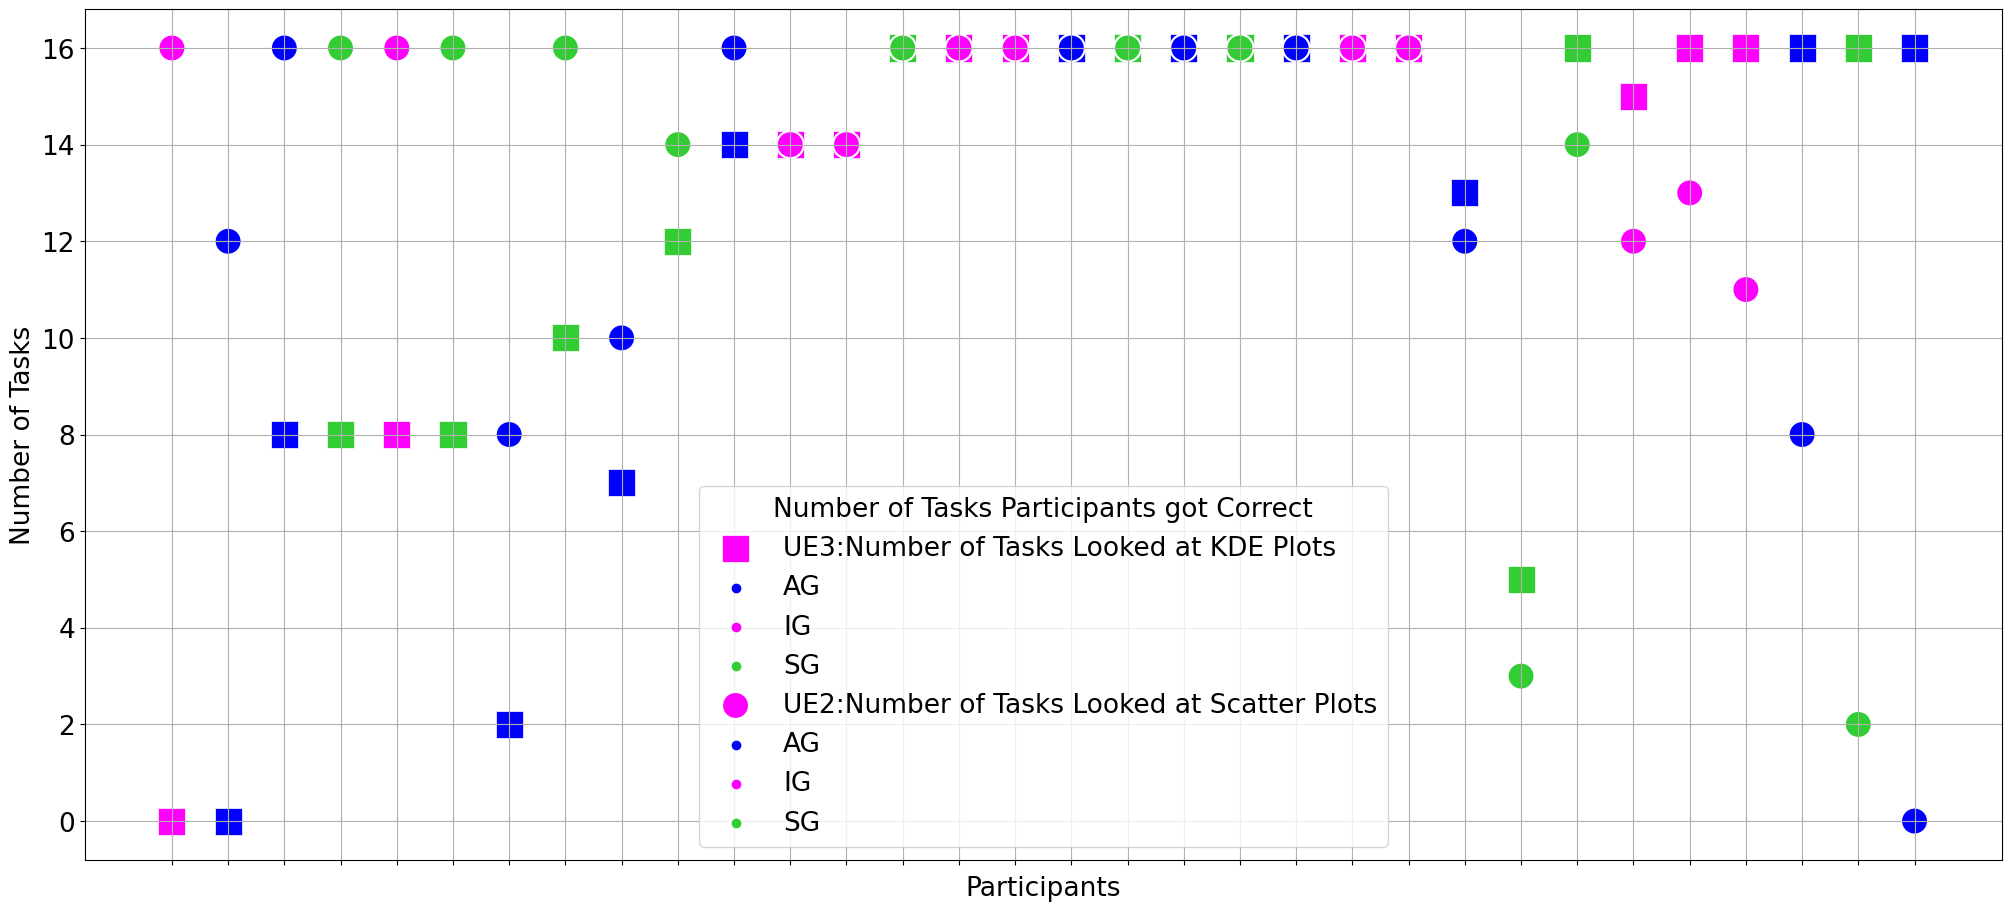

In [30]:
font_size = 19
plt.rcParams.update({'font.size': font_size})
fig = plt.figure(constrained_layout=True,figsize=(20, 9))
plt.grid()
# g = sns.scatterplot(df_perf_part.sort_values(['ue3','ue2','num_tasks_correct']), x="participant_id", y="ue2", color='blue',s =140,label='UE2:Number of Tasks Looked at Scatter Plots',hue='num_tasks_correct', palette='flare')
# sns.scatterplot(df_perf_part.sort_values(['ue3','ue2','num_tasks_correct']), x="participant_id", y="ue3",ax=g,marker='s',edgecolors='coral',linewidth=0.5,label='UE3:Number of Tasks Looked at KDE Plots',hue='num_tasks_correct', palette='flare')
 
g =sns.scatterplot(df_perf_part[df_perf_part['condition']!='all'].sort_values(['ue3-ue2','ue3','ue2','num_tasks_correct']), x="participant_id", y="ue3",marker='s',s =380,edgecolors='coral',linewidth=0.5,label='UE3:Number of Tasks Looked at KDE Plots',hue='condition', palette=p_plain, hue_order=hue_order_plain)
sns.scatterplot(df_perf_part[df_perf_part['condition']!='all'].sort_values(['ue3-ue2','ue3','ue2','num_tasks_correct']), x="participant_id", y="ue2",ax=g, color='blue',s =380,label='UE2:Number of Tasks Looked at Scatter Plots',hue='condition', palette=p_plain, hue_order=hue_order_plain)

g.legend_.set_title('Number of Tasks Participants got Correct')
p=[]
for i in range(32):
    # p.append("p"+str(i))
    p.append("")
g.set_xticklabels(p)
g.set(ylabel='Number of Tasks')
g.set(xlabel='Participants')
g.get_figure().savefig('ch6_ue_condition.svg',dpi=300)

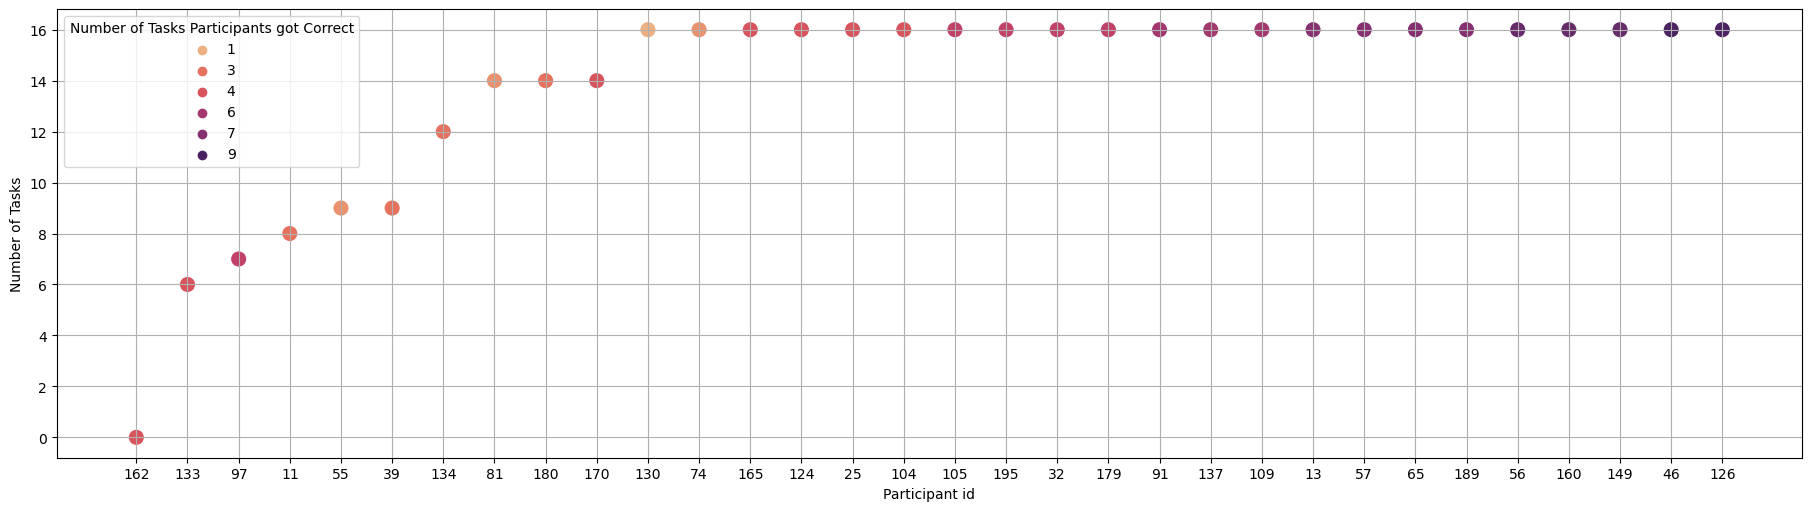

In [17]:
fig = plt.figure(constrained_layout=True,figsize=(18, 5))
plt.grid()
# g = sns.scatterplot(l1all.sort_values('cat'), x="participant_id", y="cat", color='blue',label='UE2:No Tasks Looked at Scatter Plots')
# sns.scatterplot(l2all.sort_values('cat'), x="participant_id", y="cat",ax=g,color='orange',label='UE3:No Tasks Looked at KDE Plots')
g = sns.scatterplot(df_perf_part[df_perf_part['condition']=='all'].sort_values(['ue1','num_tasks_correct']), x="participant_id", y="ue1", color='blue',s =140,hue='num_tasks_correct', palette='flare')
g.set(ylabel='Number of Tasks')
g.legend_.set_title('Number of Tasks Participants got Correct')
g.set(xlabel='Participant id')
g.get_figure().savefig('ch6_ue1_perf.svg',dpi=300)

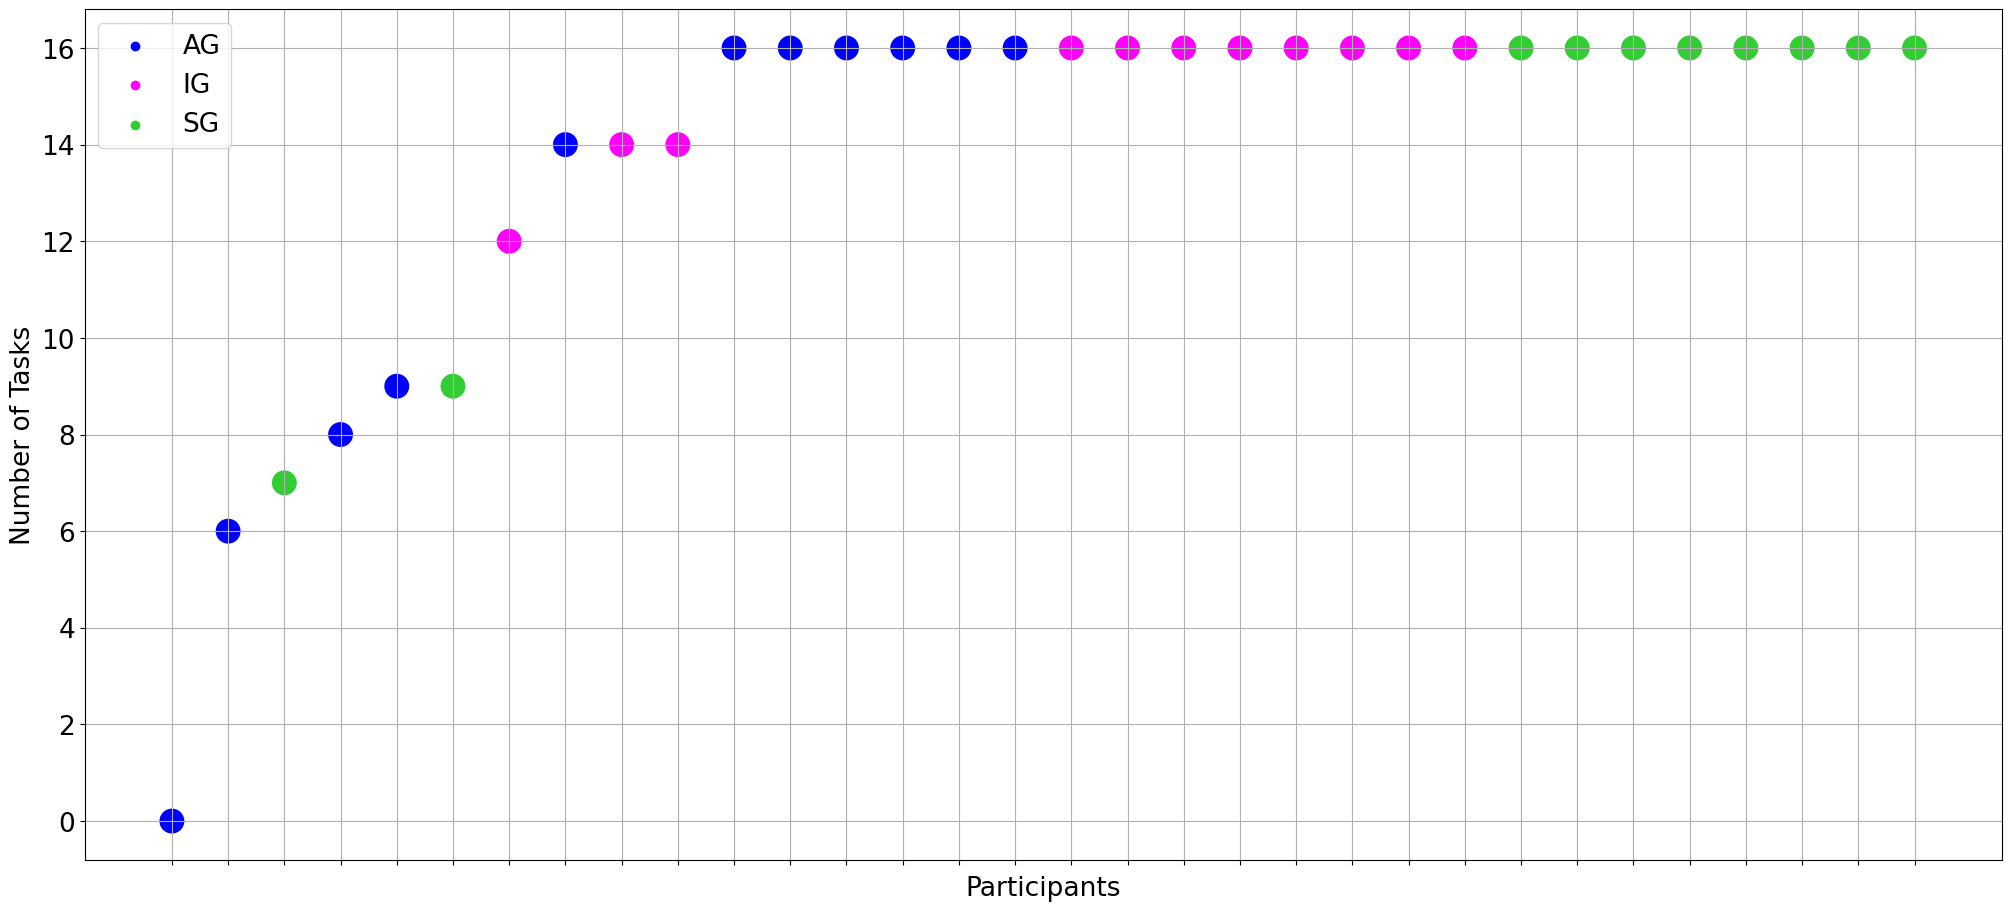

In [31]:
font_size = 19
plt.rcParams.update({'font.size': font_size})
fig = plt.figure(constrained_layout=True,figsize=(20, 9))
plt.grid()
# g = sns.scatterplot(l1all.sort_values('cat'), x="participant_id", y="cat", color='blue',label='UE2:No Tasks Looked at Scatter Plots')
# sns.scatterplot(l2all.sort_values('cat'), x="participant_id", y="cat",ax=g,color='orange',label='UE3:No Tasks Looked at KDE Plots')
g = sns.scatterplot(df_perf_part[df_perf_part['condition']!='all'].sort_values(['ue1','condition']), x="participant_id", y="ue1", color='blue',s =380,hue='condition', palette=p_plain, hue_order=hue_order_plain)
g.set(ylabel='Number of Tasks')
g.legend_.set_title('')
p=[]
for i in range(32):
    # p.append("p"+str(i))
    p.append("")
g.set_xticklabels(p)
g.set(xlabel='Participants')
g.get_figure().savefig('ch6_ue1_perf.svg',dpi=300)

[Text(0.5, 0, 'Number of Tasks')]

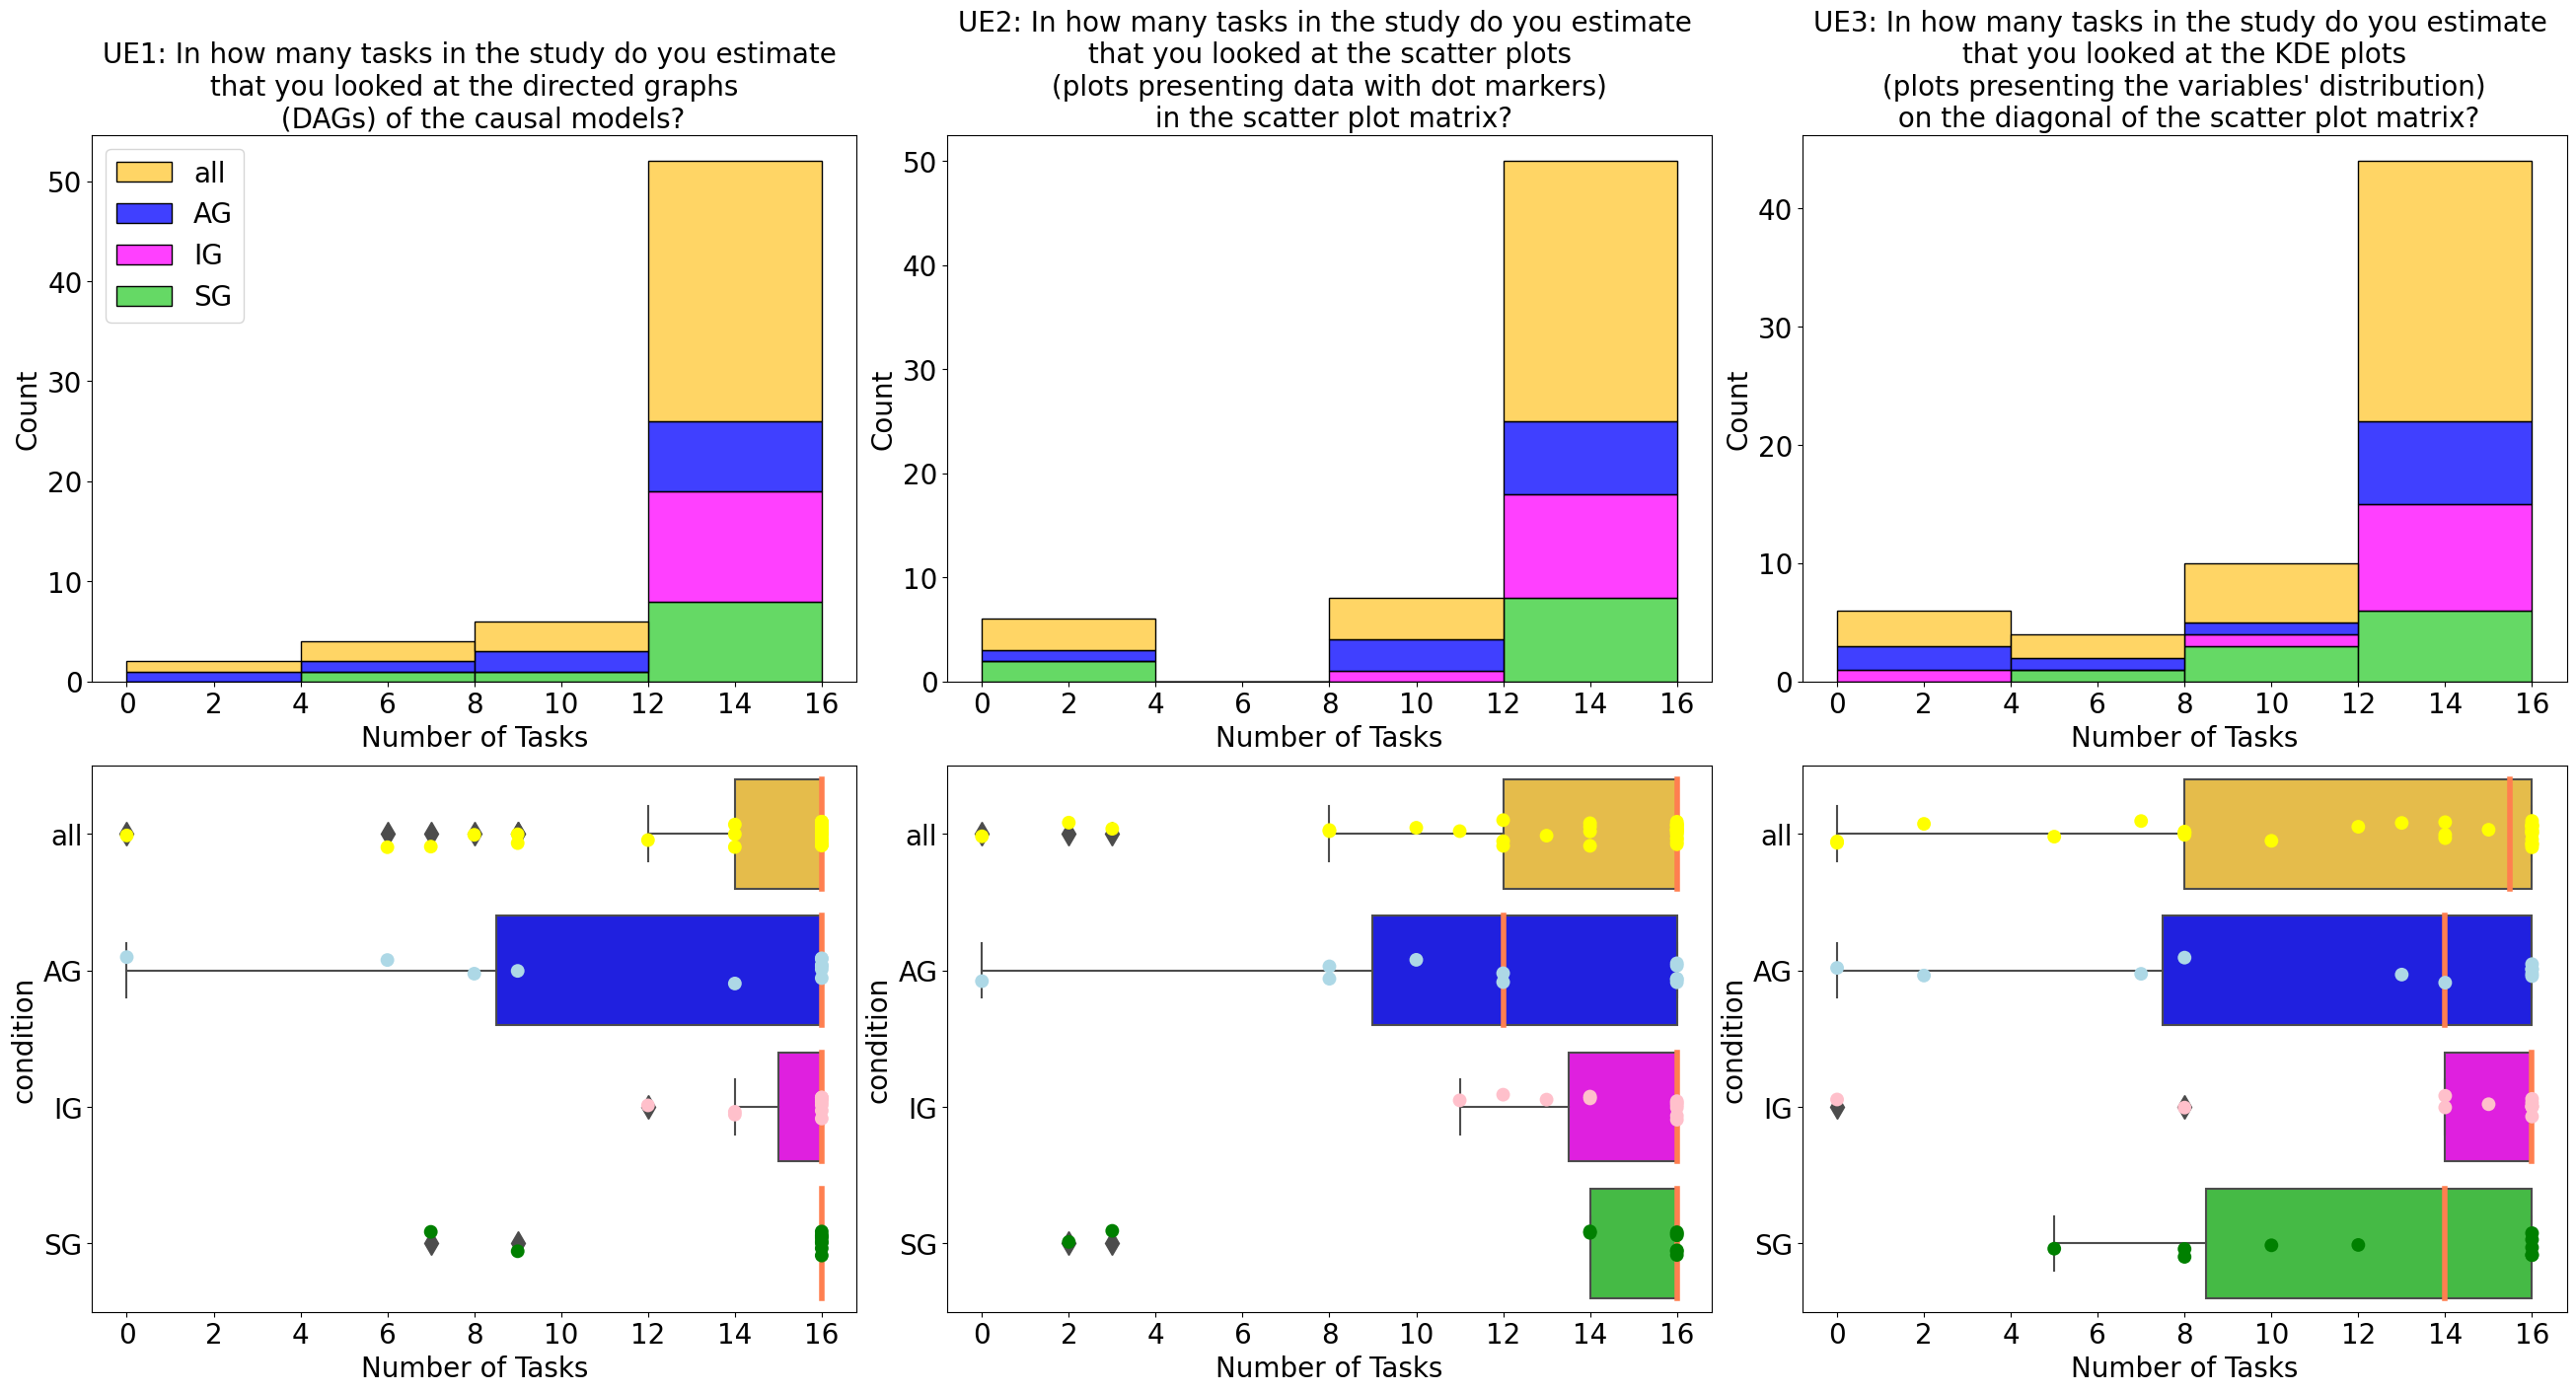

In [37]:
fig = plt.figure(constrained_layout=True,figsize=(26, 14))
font_size = 20
plt.rcParams.update({'font.size': font_size})
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 0:2])
ax5 = fig.add_subplot(gs[1, 2:4])
ax6 = fig.add_subplot(gs[1, 4:6])

g1 =  sns.histplot(df_perf_part, x='ue1', hue = 'condition', palette = p_all, multiple='stack', hue_order = hue_order,bins = 4,ax=ax1)
g1.legend_.set_title(None)
ax1.set_title("UE1: In how many tasks in the study do you estimate \n that you looked at the directed graphs \n  (DAGs) of the causal models?")
ax1.tick_params(axis='both')

g2 =  sns.histplot(df_perf_part, x='ue2', hue = 'condition', palette = p_all, multiple='stack', hue_order = hue_order,bins = 4,ax=ax2)
g2.legend_.set_title(None)
g2.legend_.remove()
ax2.set_title("UE2: In how many tasks in the study do you estimate \n that you looked at the scatter plots \n (plots presenting data with dot markers) \n in the scatter plot matrix?")
ax2.tick_params(axis='both')

g3 =  sns.histplot(df_perf_part, x='ue3', hue = 'condition', palette = p_all, multiple='stack', hue_order = hue_order,bins = 4,ax=ax3)
g3.legend_.set_title(None)
g3.legend_.remove()
ax3.set_title("UE3: In how many tasks in the study do you estimate \n that you looked at the KDE plots \n (plots presenting the variables' distribution) \n on the diagonal of the scatter plot matrix?")
ax3.tick_params(axis='both')

g4 =  sns.boxplot(df_perf_part, x='ue1', y='condition', palette = p_all, order = hue_order, ax=ax4,medianprops={"color": "coral",'linewidth':4},fliersize=12)
sns.stripplot(data=df_perf_part, size=10, ax=ax4, x="ue1", y="condition", order = hue_order,palette = {'all':'yellow',"IG":"pink","AG":"lightblue","SG":"green"})
# ax4.set_title("UE1: In how many tasks in the study do you estimate \n that you looked at the directed graphs \n  (DAGs) of the causal models?")
ax4.tick_params(axis='both')

g5 =  sns.boxplot(df_perf_part, y='condition', x='ue2', palette = p_all, order = hue_order, ax=ax5,medianprops={"color": "coral",'linewidth':4},fliersize=12)
sns.stripplot(data=df_perf_part, size=10, ax=ax5, x="ue2", y="condition", order = hue_order,palette = {'all':'yellow',"IG":"pink","AG":"lightblue","SG":"green"})
# ax5.set_title("UE2: In how many tasks in the study do you estimate \n that you looked at the scatter plots \n (plots presenting data with dot markers) \n in the scatter plot matrix?")
ax5.tick_params(axis='both')

g6 =  sns.boxplot(df_perf_part, y='condition', x='ue3', palette = p_all, order = hue_order, ax=ax6,medianprops={"color": "coral",'linewidth':4},fliersize=12)
sns.stripplot(data=df_perf_part, size=10, ax=ax6, x="ue3", y="condition", order = hue_order,palette = {'all':'yellow',"IG":"pink","AG":"lightblue","SG":"green"})
# ax6.set_title("UE3: In how many tasks in the study do you estimate \n that you looked at the KDE plots \n (plots presenting the variables' distribution) \n on the diagonal of the scatter plot matrix?")
ax6.tick_params(axis='both')

g_axes = [ax1,ax2,ax3,ax4,ax5,ax6]
for i,ax in enumerate(g_axes):
    ax.tick_params(axis='both', labelsize=font_size)
    ax.yaxis.label.set_size(font_size)
    ax.title.set_size(font_size)

ax1.set(xlabel='Number of Tasks')
ax2.set(xlabel='Number of Tasks')
ax3.set(xlabel='Number of Tasks')
ax4.set(xlabel='Number of Tasks')
ax5.set(xlabel='Number of Tasks')
ax6.set(xlabel='Number of Tasks')
# plt.savefig('ch6_Fig8.pdf',dpi=300)

[Text(0.5, 0, 'Number of Tasks')]

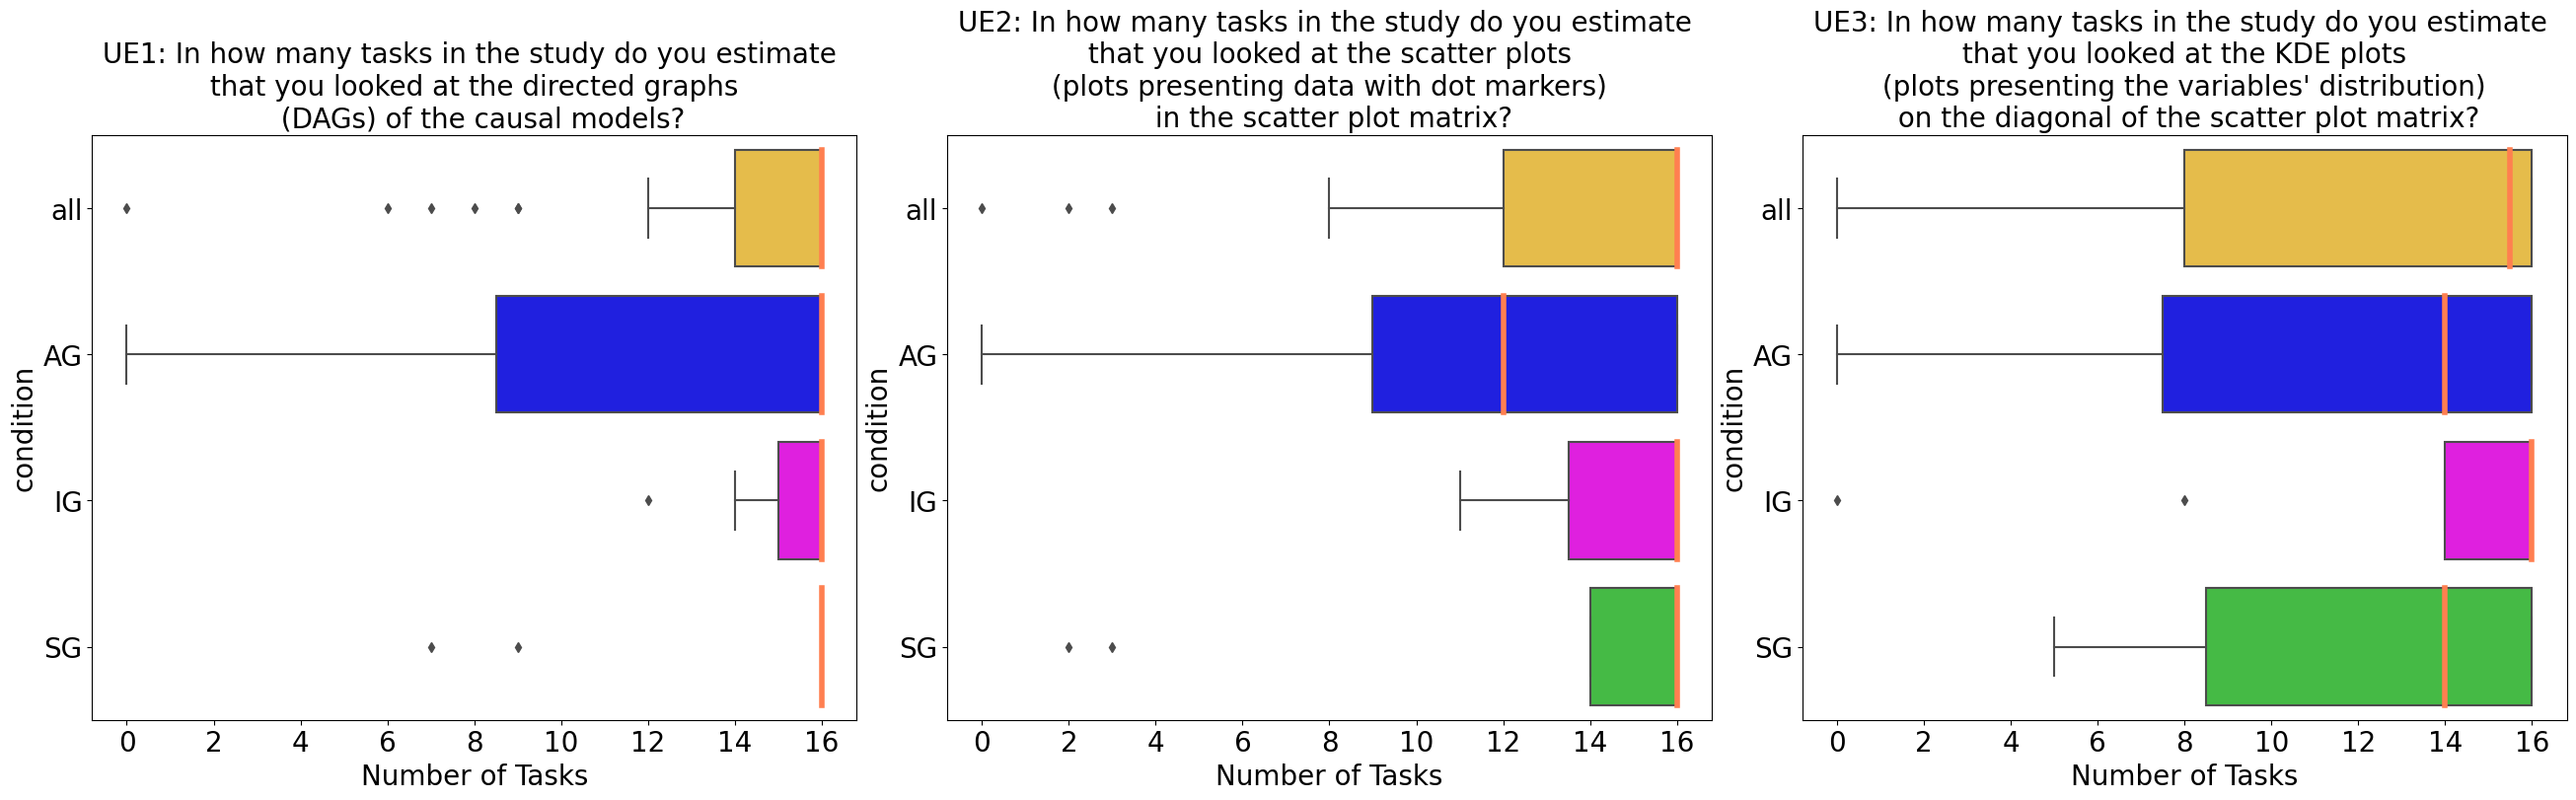

In [115]:
fig = plt.figure(constrained_layout=True,figsize=(26, 8))
font_size = 20
plt.rcParams.update({'font.size': font_size})
gs = GridSpec(1, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

g1 =  sns.boxplot(df_perf_part, y='condition', x='ue1', palette = p_all, order = hue_order, ax=ax1,medianprops={"color": "coral",'linewidth':4})
ax1.set_title("UE1: In how many tasks in the study do you estimate \n that you looked at the directed graphs \n  (DAGs) of the causal models?")
ax1.tick_params(axis='both')

g2 =  sns.boxplot(df_perf_part, y='condition', x='ue2', palette = p_all, order = hue_order, ax=ax2,medianprops={"color": "coral",'linewidth':4})
ax2.set_title("UE2: In how many tasks in the study do you estimate \n that you looked at the scatter plots \n (plots presenting data with dot markers) \n in the scatter plot matrix?")
ax2.tick_params(axis='both')

g3 =  sns.boxplot(df_perf_part, y='condition', x='ue3', palette = p_all, order = hue_order, ax=ax3,medianprops={"color": "coral",'linewidth':4})
ax3.set_title("UE3: In how many tasks in the study do you estimate \n that you looked at the KDE plots \n (plots presenting the variables' distribution) \n on the diagonal of the scatter plot matrix?")
ax3.tick_params(axis='both')

g_axes = [ax1,ax2,ax3]
for i,ax in enumerate(g_axes):
    ax.tick_params(axis='both', labelsize=font_size)
    ax.yaxis.label.set_size(font_size)
    ax.title.set_size(font_size)

ax1.set(xlabel='Number of Tasks')
ax2.set(xlabel='Number of Tasks')
ax3.set(xlabel='Number of Tasks')

# plt.savefig('ch6_Fig8.pdf',dpi=300)

### Plot accuracy per task and condition

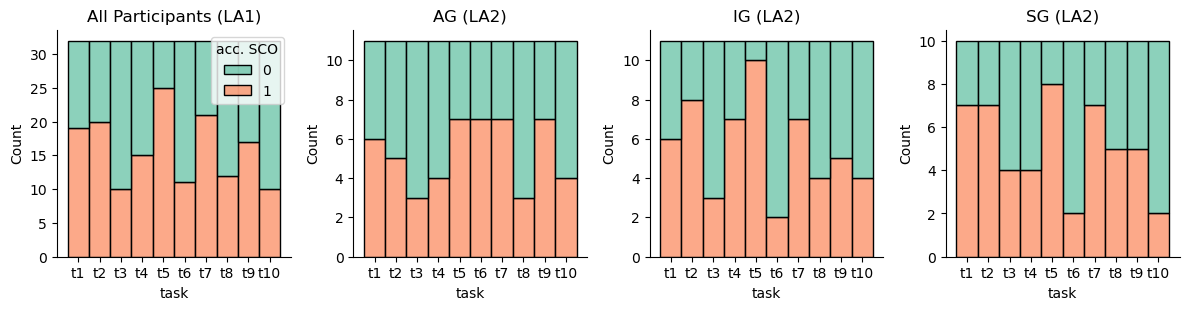

In [14]:
g = sns.FacetGrid(df, col="condition", col_order = hue_order, sharey=False)
sns.histplot(df[df['condition']=='all'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[0], palette = sns.color_palette("Set2"))
sns.histplot(df[df['condition']=='AG'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[1], palette = sns.color_palette("Set2"))
sns.histplot(df[df['condition']=='IG'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[2], palette = sns.color_palette("Set2"))
sns.histplot(df[df['condition']=='SG'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[3], palette = sns.color_palette("Set2"))
g.fig.axes[3].legend_.remove()
g.fig.axes[1].legend_.remove()
g.fig.axes[2].legend_.remove()
g.fig.axes[0].legend_.set_title("acc. SCO")

g.fig.axes[0].set_title('All Participants (LA1)')
g.fig.axes[1].set_title('AG (LA2)')
g.fig.axes[2].set_title('IG (LA2)')
g.fig.axes[3].set_title('SG (LA2)')

g.fig.savefig('ch6_sco_scores.svg',dpi=300)

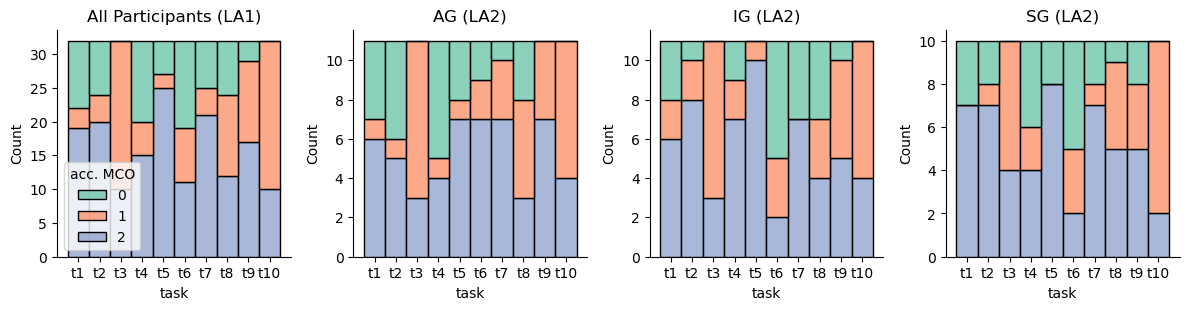

In [16]:
g = sns.FacetGrid(df, col="condition", col_order = hue_order, sharey=False)
sns.histplot(df[df['condition']=='all'], x="task", hue='accuracy_ham', multiple="stack", ax = g.fig.axes[0], palette = sns.color_palette("Set2"))
sns.histplot(df[df['condition']=='AG'], x="task", hue='accuracy_ham', multiple="stack", ax = g.fig.axes[1], palette = sns.color_palette("Set2"))
sns.histplot(df[df['condition']=='IG'], x="task", hue='accuracy_ham', multiple="stack", ax = g.fig.axes[2], palette = sns.color_palette("Set2"))
sns.histplot(df[df['condition']=='SG'], x="task", hue='accuracy_ham', multiple="stack", ax = g.fig.axes[3], palette = sns.color_palette("Set2"))

g.fig.axes[3].legend_.remove()
g.fig.axes[1].legend_.remove()
g.fig.axes[2].legend_.remove()
g.fig.axes[0].legend_.set_title("acc. MCO")

g.fig.axes[0].set_title('All Participants (LA1)')
g.fig.axes[1].set_title('AG (LA2)')
g.fig.axes[2].set_title('IG (LA2)')
g.fig.axes[3].set_title('SG (LA2)')

g.fig.savefig('ch6_mco_scores.svg',dpi=300)

<AxesSubplot: title={'center': 'condition = SG'}, xlabel='task', ylabel='Count'>

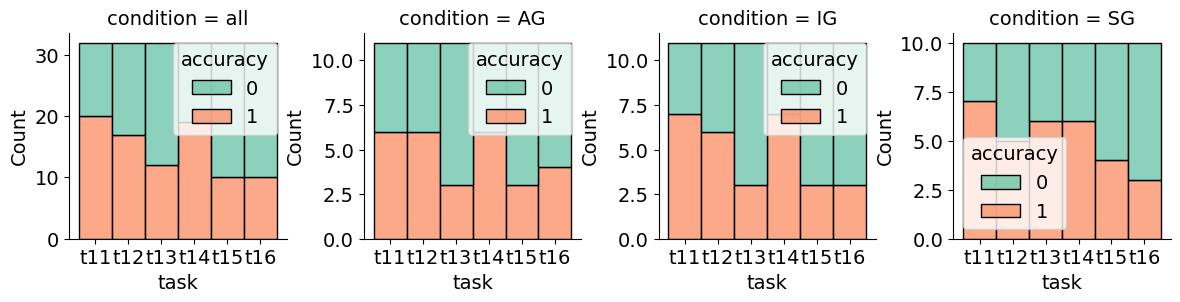

In [14]:
g = sns.FacetGrid(df_T2_model, col="condition", col_order = hue_order, sharey=False)
sns.histplot(df_T2_model[df_T2_model['condition']=='all'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[0], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_model[df_T2_model['condition']=='AG'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[1], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_model[df_T2_model['condition']=='IG'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[2], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_model[df_T2_model['condition']=='SG'], x="task", hue='accuracy', multiple="stack", ax = g.fig.axes[3], palette = sns.color_palette("Set2"))

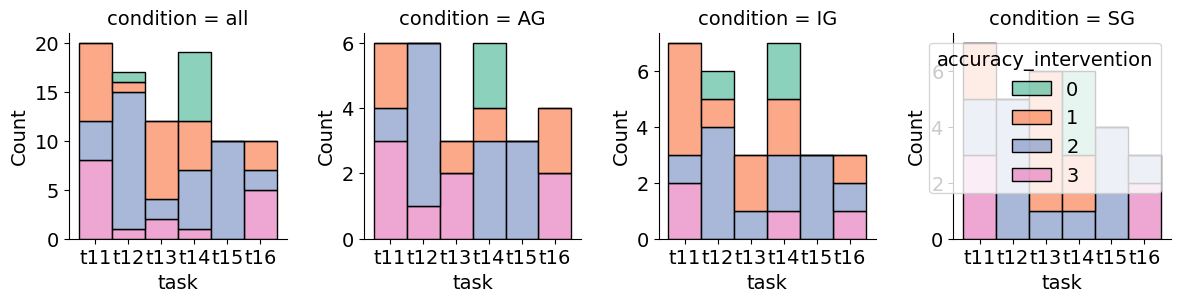

In [44]:
font_size = 14
plt.rcParams.update({'font.size': font_size})
## participants who got the model correct
df_T2_corr_model = df_T2_model[df_T2_model['accuracy']==1]
g = sns.FacetGrid(df_T2_corr_model, col="condition", col_order = hue_order, sharey=False)
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='all'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[0], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='AG'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[1], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='IG'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[2], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='SG'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[3], palette = sns.color_palette("Set2"))

g.fig.axes[0].legend_.remove()
g.fig.axes[1].legend_.remove()
g.fig.axes[2].legend_.remove()

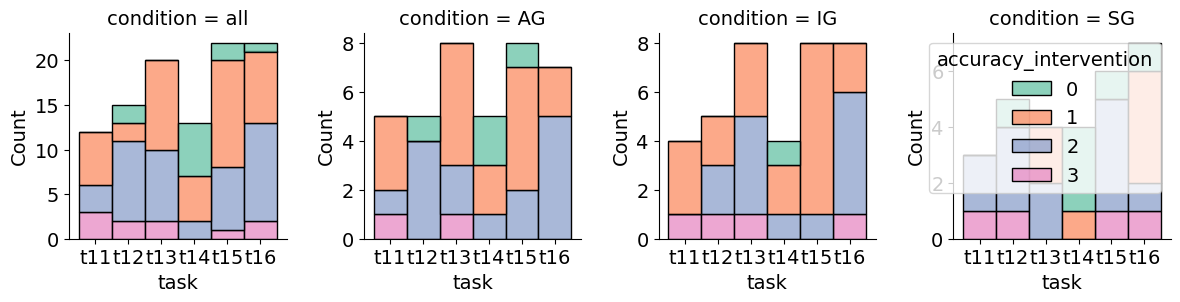

In [45]:
font_size = 14
plt.rcParams.update({'font.size': font_size})
## participants who got the model wrong
df_T2_corr_model = df_T2_model[df_T2_model['accuracy']==0]
g = sns.FacetGrid(df_T2_corr_model, col="condition", col_order = hue_order, sharey=False)
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='all'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[0], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='AG'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[1], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='IG'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[2], palette = sns.color_palette("Set2"))
sns.histplot(df_T2_corr_model[df_T2_corr_model['condition']=='SG'], x="task", hue='accuracy_intervention', multiple="stack", ax = g.fig.axes[3], palette = sns.color_palette("Set2"))

g.fig.axes[0].legend_.remove()
g.fig.axes[1].legend_.remove()
g.fig.axes[2].legend_.remove()

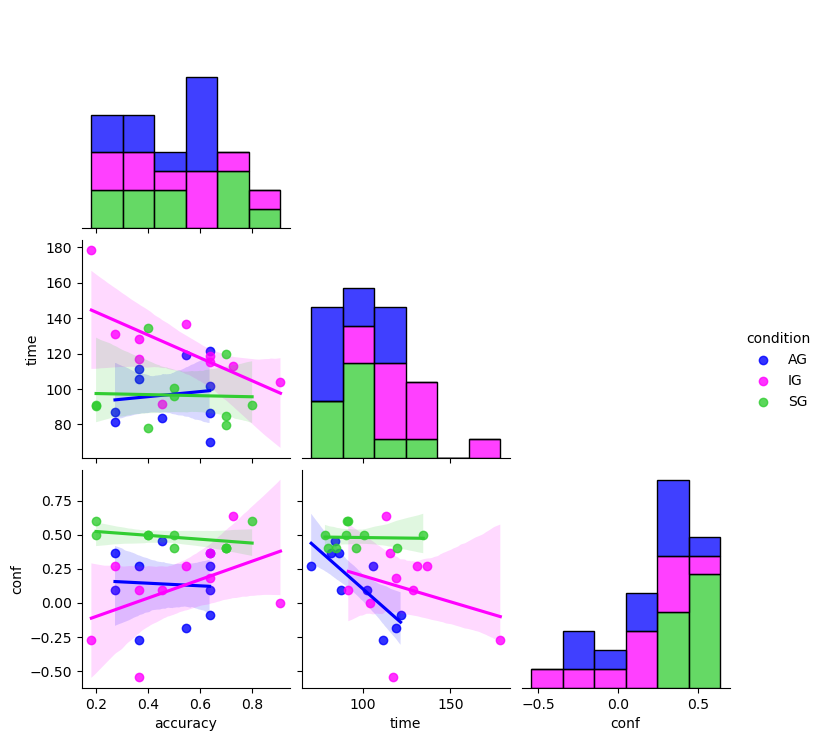

In [99]:
# p = {'atomic':'blue','shift':'magenta','variance':'#32CD32'}
# hue_order = ['atomic','shift','variance']
df_scatter = df[df['condition']!='all'].groupby(['task', 'condition'], as_index=False)['accuracy','time','conf'].mean()
g = sns.pairplot(df_scatter, palette = p_plain, hue_order=hue_order_plain, corner=True, diag_kind='hist', kind = 'reg', hue = 'condition', vars=['accuracy','time','conf'], diag_kws={'multiple':'stack'})
# add_labels(g.fig.axes[1], df_scatter['accuracy'],df_scatter['time'],df_scatter['task'])
# add_labels(g.fig.axes[4], pp_data['response_time'],pp_data['confidence'],pp_data['task'],pp_data['color'])
# add_labels(g.fig.axes[3], pp_data['accuracy'],pp_data['confidence'],pp_data['task'],pp_data['color'])

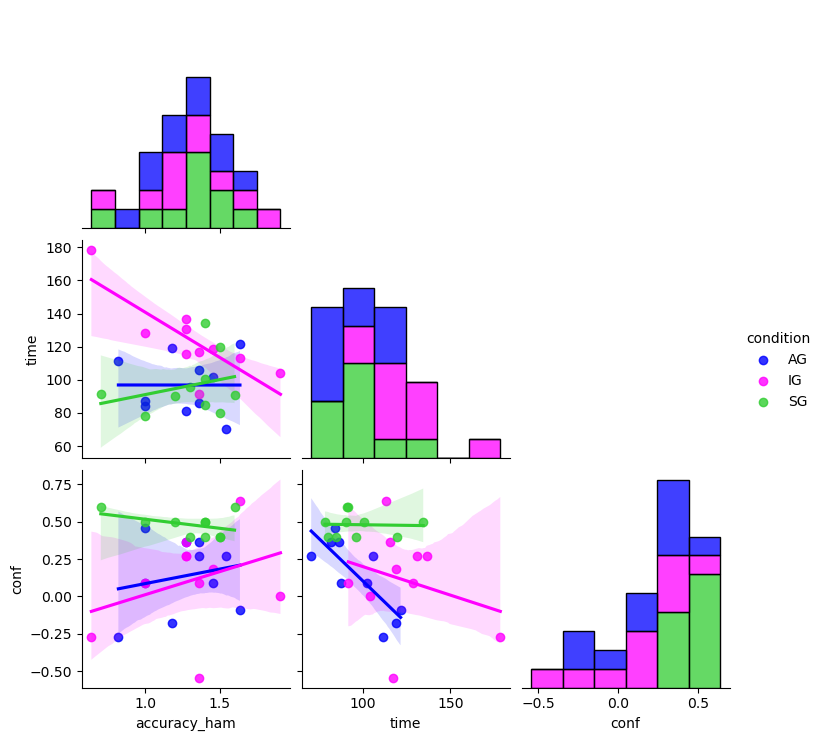

In [71]:
df_scatter = df[df['condition']!='all'].groupby(['task', 'condition'], as_index=False)['accuracy_ham','time','conf'].mean()
g = sns.pairplot(df_scatter, palette = p_plain, hue_order=hue_order_plain, corner=True, diag_kind='hist', kind = 'reg', hue = 'condition', vars=['accuracy_ham','time','conf'], diag_kws={'multiple':'stack'})

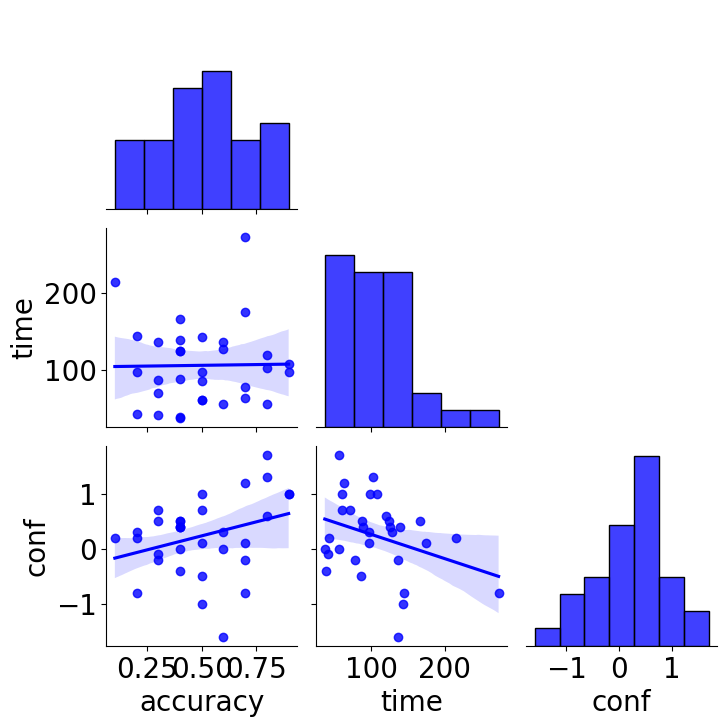

In [128]:
sns.pairplot(df[df['condition']=='all'].groupby(['participant'], as_index=False)['accuracy','time','conf'].mean(), vars=['accuracy','time','conf'],corner=True, diag_kind='hist',kind = 'reg',plot_kws={'color':'blue'},diag_kws={'color':'blue'})

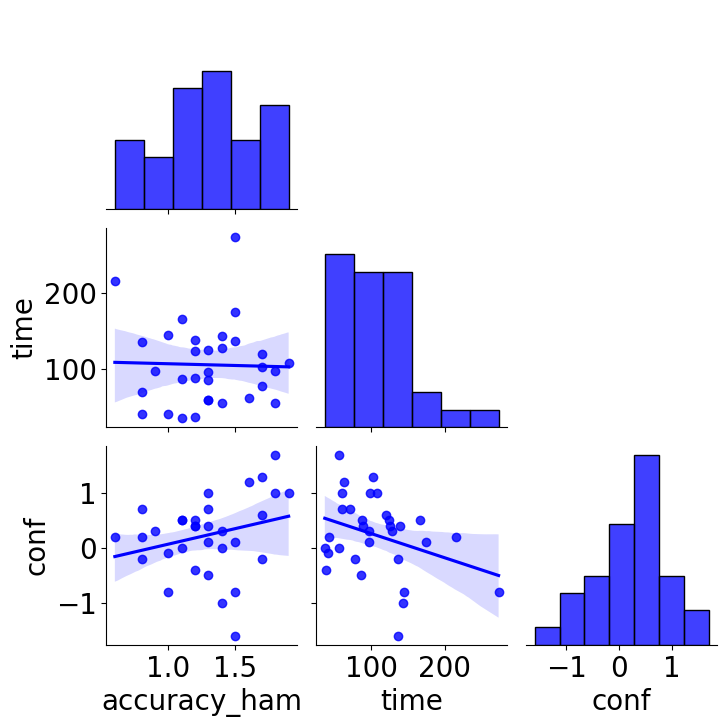

In [125]:
sns.pairplot(df[df['condition']=='all'].groupby(['participant'], as_index=False)['accuracy_ham','time','conf'].mean(), vars=['accuracy_ham','time','conf'],corner=True, diag_kind='hist',kind = 'reg',plot_kws={'color':'blue'},diag_kws={'color':'blue'})

### Intervention Type

<AxesSubplot: xlabel='accuracy', ylabel='Probability'>

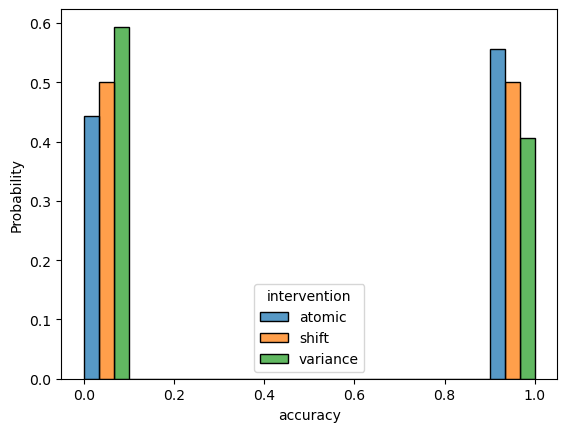

In [125]:
sns.histplot(df[df['condition']!='all'], x="accuracy", hue='intervention',stat='probability',common_norm = False,multiple="dodge")

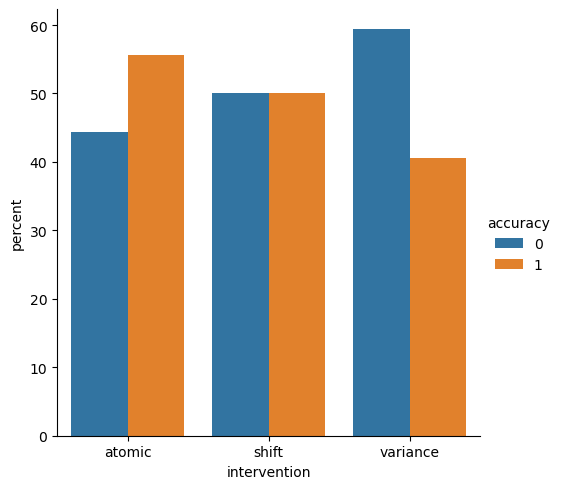

In [120]:
df_hist = df[df['condition']!='all'].groupby('intervention')['accuracy'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='intervention',y='percent',hue='accuracy',kind='bar')
# df_hist
# sns.histplot(df_hist, x="intervention", hue='accuracy',y='percent', multiple="stack")

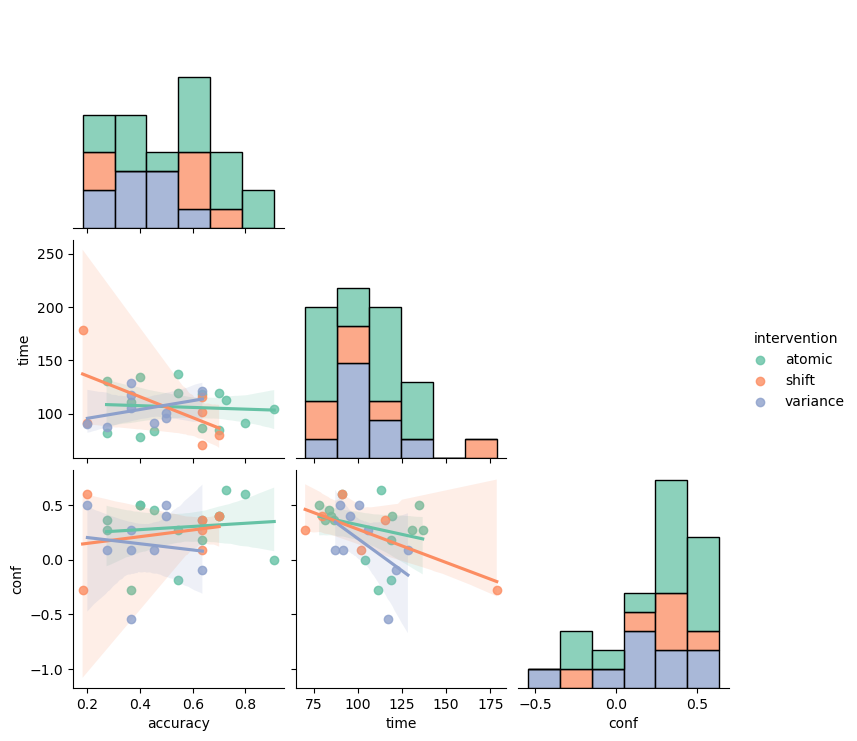

In [72]:
hue_order_interv = ['atomic','shift','variance']
df_scatter = df[df['condition']!='all'].groupby(['task', 'condition','intervention'], as_index=False)['accuracy','time','conf'].mean()
g = sns.pairplot(df_scatter, palette = sns.color_palette("Set2"), hue_order=hue_order_interv, corner=True, diag_kind='hist', kind = 'reg', hue = 'intervention', vars=['accuracy','time','conf'], diag_kws={'multiple':'stack'})
# add_labels(g.fig.axes[1], df_scatter['accuracy'],df_scatter['time'],df_scatter['task'])
# add_labels(g.fig.axes[4], pp_data['response_time'],pp_data['confidence'],pp_data['task'],pp_data['color'])
# add_labels(g.fig.axes[3], pp_data['accuracy'],pp_data['confidence'],pp_data['task'],pp_data['color'])

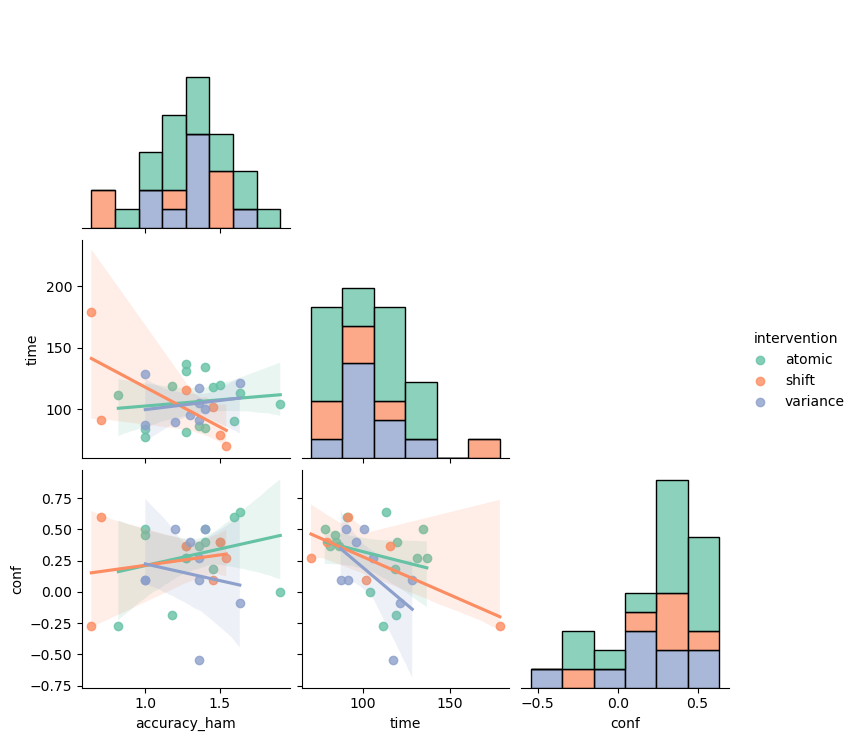

In [73]:
hue_order_interv = ['atomic','shift','variance']
df_scatter = df[df['condition']!='all'].groupby(['task', 'condition','intervention'], as_index=False)['accuracy_ham','time','conf'].mean()
g = sns.pairplot(df_scatter, palette = sns.color_palette("Set2"), hue_order=hue_order_interv, corner=True, diag_kind='hist', kind = 'reg', hue = 'intervention', vars=['accuracy_ham','time','conf'], diag_kws={'multiple':'stack'})

### UE4 User Experience Question

In [7]:
## How did you find the design of the visualization for the simulated data? Was it informative, annoying, distractive?
word_all = ""
word_a = ""
word_i = ""
word_s = ""
count_all = 0
count_a = 0
count_i = 0
count_s = 0
for p in data_processed:
    respo = data_processed[p]['ue_answers']['ue4']['text']
    if respo!="":
        ## all
        count_all = count_all + 1
        if word_all!="":
            word_all = word_all + " " +respo
        else:
            word_all = respo
        ## IG
        if data_processed[p]['mode'] == 'i':
            count_i = count_i + 1
            if word_i!="":
                word_i = word_i + "$$" +respo
            else:
                word_i = respo
        ## SG
        if data_processed[p]['mode'] == 's':
            count_s = count_s + 1
            if word_s!="":
                word_s = word_s + "$$" +respo
            else:
                word_s = respo
        ## AG
        if data_processed[p]['mode'] == 'a':
            count_a = count_a + 1
            if word_a!="":
                word_a = word_a + "$$" +respo
            else:
                word_a = respo
print(count_all,count_i,count_a,count_s)
# print('ALL', word_all)
print('IG', word_i)
print('AG', word_a)
print('SG',word_s)

27 10 9 8
IG It gave information in a simple, clear and organized way.$$Informative$$Good$$Very Informative$$I found it distractive $$Very good and easy to understand the changes. $$Informative, the visualization was actually very good$$annoying, lengthy $$Could have been spaced out a little more.$$Informative but too descriptive at times

AG The visualisations were informative and fairly easy to follow.$$I found it useful; I like that it was animated and you could see how changing one variable "moves" the others$$the colours were a good contrast - the scatter graph i found easier to view$$Informative but complex$$Informative$$informative$$Informative$$The design of visualization for simulated data was informative but repetitive after a point of time. Overall it gave good information.$$Clear enough
SG A bit distractive but on the whole comprehensive$$Informative$$informative$$Informative$$Informative$$Quite informative$$Somewhat informative$$it was what it needed to be
